# Libs

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV,ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Introducción

## Introducción al problema

La optimización de la producción agrícola es un pilar fundamental para la sostenibilidad y competitividad del sector agroindustrial. Para el Ingenio La Providencia, la variabilidad en el rendimiento de la caña por hectárea (TCH) y en la calidad de la materia prima (medida por el % de sacarosa) representa un desafío constante en la planificación de sus operaciones. Esta incertidumbre puede afectar directamente la logística de la cosecha, la eficiencia de los procesos en planta y, en última instancia, la rentabilidad del negocio.

El presente proyecto aborda este desafío mediante la aplicación de técnicas de machine learning sobre los datos históricos del ingenio. El objetivo principal es desarrollar modelos predictivos capaces de estimar con precisión dos indicadores críticos:

1.  **Las Toneladas de Caña por Hectárea (TCH)**, para anticipar el volumen de producción.
2.  **El Porcentaje de Sacarosa (%Sac.Caña)**, para prever la calidad y el potencial de azúcar extraíble.

Adicionalmente, se busca crear un sistema de clasificación que categorice el desempeño de los cultivos en niveles **alto, medio y bajo** para ambas variables. La implementación exitosa de estos modelos permitirá al Ingenio La Providencia pasar de una toma de decisiones reactiva a una estrategia proactiva, optimizando la gestión de recursos, mejorando la planificación de la zafra y maximizando tanto la productividad como la calidad de su producción.

## Descripción del Conjunto de Datos



Los datos provenientes de la base de datos **`HISTORICO_SUERTES.xlsx`** conforman un registro detallado de las operaciones agrícolas y los resultados de producción del Ingenio La Providencia. Se presume que cada fila representa un evento de cosecha para una "suerte" (lote de cultivo) específica. El conjunto de variables puede interpretarse y agruparse en las siguientes categorías funcionales:

### 1. Variables de Identificación y Agronómicas Fundamentales
Este grupo de variables permite identificar de manera única cada lote y describe sus características físicas y de cultivo.
* **Identificadores:** `Hacienda`, `Nombre` y `Suerte` funcionan como el identificador único de cada parcela. `Zona` y `Dist Km` la sitúan geográficamente y establecen su distancia a la planta, un factor logístico clave.
* **Características del Cultivo:** `Area Neta` define la superficie productiva del lote. Variables como `Suelo`, `Variedad`, `F.Siembra`, y `Cod.Estado` (que indica el número de corte, ej. "Plantilla" para la primera siembra o "Corte 2" para la segunda cosecha) son fundamentales, ya que definen el potencial genético y el ciclo de vida del cultivo.

### 2. Variables de Manejo y Prácticas Agrícolas
Aquí se registran las intervenciones humanas y las decisiones de manejo que influyen directamente en el desarrollo y la maduración de la caña.
* **Labores Culturales:** Se documentan prácticas clave como el riego (`Num.Riegos`, `M3 Riego`, `Ult.Riego`), la fertilización (`Fert.Nitrogen.`, `Urea 46%`, `Vinaza`) y el uso de madurantes químicos (`Producto`, `Dosis Madurante`), que son palancas críticas para optimizar el rendimiento.
* **Cosecha:** Variables como `Tipo Quema` (verde o quemada) y `T.Corte` (mecanizado o manual) describen el método de cosecha, el cual tiene un impacto directo en la calidad de la materia prima que llega al ingenio.

### 3. Variables de Producción y Calidad (Variables Objetivo)
Este es el grupo más importante, ya que contiene los indicadores de desempeño que se busca predecir.
* **Productividad:** La variable principal es **`TCH` (Toneladas de Caña por Hectárea)**, que mide el rendimiento agrícola del lote. Está directamente relacionada con `TonUltCorte`, que es la producción total en toneladas.
* **Calidad:** La variable clave de calidad es **`%Sac.Caña`**, que representa el porcentaje de sacarosa en la caña y determina su valor para la producción de azúcar. Se complementa con otras métricas como `Rdto` (Rendimiento industrial) y `%ATR` (Azúcares Totales Recuperables), que también reflejan la eficiencia en la extracción de azúcar.

### 4. Variables Climáticas y Ambientales
El desempeño de un cultivo depende en gran medida del entorno. Este grupo de variables busca capturar esas condiciones.
* **Clima:** Se registran datos meteorológicos cruciales como `Lluvias`, `Temp. Media`, `Humedad Rel Media` y `Radiacion Solar`. Es notable que estas variables están agregadas en diferentes ventanas de tiempo (ej. `0-3 meses`, `Ciclo completo`), lo que permite analizar cómo las condiciones climáticas en distintas etapas fenológicas del cultivo afectan el resultado final.
* **Sanidad:** La variable `%Infest.Diatrea` es un indicador de la salud del cultivo, midiendo el impacto de una de las plagas más significativas de la caña de azúcar.

La base de datos **`BD_IPSA_1940.xlsx`** proporciona un conjunto de variables consolidadas, orientadas a la tarea de clasificación del desempeño de los lotes. A diferencia del set de datos históricos para regresión, este parece estar más enfocado en factores agronómicos clave y los resultados finales de cosecha. Cada fila representa un evento de cosecha para una variedad específica, CC01-1940.

Las variables presentes pueden agruparse e interpretarse de la siguiente manera:

### 1. Variables de Identificación y Características del Cultivo
Este grupo de variables permite identificar el lote y define sus condiciones agronómicas básicas.
* **Identificadores:** `NOME`, `FAZ` (Hacienda) y `TAL` (Talhão o Suerte) identifican la unidad productiva específica.
* **Características Agronómicas:** `variedad` especifica el tipo de caña. `tipocorte` describe el método de cosecha. `cortes` indica el número de cosechas que ha tenido la planta (su ciclo de soca), y `edad` representa la edad del cultivo en meses al momento del corte, dos factores determinantes en la productividad.

### 2. Variables de Manejo de Maduración
Un conjunto de variables está dedicado exclusivamente a la práctica de maduración química, sugiriendo su importancia como factor predictivo.
* `madurada`: Es una variable categórica (SI/NO) que indica si se aplicó o no un producto para inducir la maduración.
* `producto`, `dosismad` (Dosis del Madurante) y `semsmad` (Semanas desde la aplicación hasta la cosecha): Detallan el tipo de madurante utilizado, la cantidad y el tiempo de acción, lo que permite evaluar la efectividad de esta práctica agrícola.

### 3. Indicadores de Desempeño y Calidad (Variables a Clasificar)
Estas son las variables centrales del problema. A partir de ellas se construirán las categorías de "alto", "medio" y "bajo" rendimiento.
* **Variables Objetivo (Continuas):** **`TCH` (Toneladas de Caña por Hectárea)** y **`sacarosa` (%)** son los indicadores directos de la productividad agrícola y la calidad industrial, respectivamente. Estos valores serán la base para crear las etiquetas de clasificación.
* **Indicadores Adicionales:** `pct_diatrea` (% de infestación de Diatraea) y `me` (probablemente Materia Extraña) son métricas que reflejan la sanidad y limpieza del cultivo, factores que impactan negativamente tanto el TCH como la sacarosa. `vejez` podría indicar el tiempo en horas o días entre el corte y la molienda, un factor crítico para la calidad.

### 4. Variables de Contexto Temporal y Ambiental
Este grupo final de variables sitúa cada cosecha en un contexto específico.
* `mes` y `periodo`: Definen el momento exacto de la cosecha, permitiendo analizar la estacionalidad.
* `lluvias`: Es una variable climática fundamental que resume las precipitaciones acumuladas en un periodo relevante para la cosecha.
* `grupo_tenencia`: Es una variable categórica que probablemente se refiere al tipo de propiedad o administración del lote (ej. propio, arrendado), lo cual puede implicar diferencias en las estrategias de manejo.

# Modelo de Regresión

## Análisis Exploratorio de Datos (EDA)

In [50]:
# Opción para ver TODAS las filas (None significa sin límite)
pd.set_option('display.max_rows', None)

# Opción para ver TODAS las columnas (None significa sin límite)
pd.set_option('display.max_columns', None)

# Opción para aumentar el ancho de la línea y evitar que se corte la tabla
pd.set_option('display.width', 1000)

In [51]:
file_name = 'data/HISTORICO_SUERTES.xlsx'

df = pd.read_excel(file_name)

df.head(3)

,Período,Hacienda,Nombre,Zona,Tenencia,Suerte,Suelo,Area Neta,Dist Km,Variedad,Cod.Estado #,Cod.Estado,F.Siembra,D.S.,Ult.Riego,Edad Ult Cos,F.Ult.Corte,Destino 1=Semilla,Cod. T.Cultivo,Cultivo,Fec.Madur.,Producto,Dosis Madurante,Semanas mad.,TonUltCorte,TCH,TCHM,Ton.Azucar,Rdto,TAH,TAHM,Sac.Caña Precosecha,Edad.Precosecha,%Sac.Caña,%Sac.Muestreadora,%ATR,KATRHM,%Fibra Caña,%AR Jugo,%ME Min,%ME Veg,%ME Tot,Brix,Pureza,Vejez,Tipo Quema,T.Corte,Cerca de,Cosechó,Num.Riegos,M3 Riego,DDUlt.Riego,Lluvias (2 Meses Ant.),Lluvias Ciclo,Lluvias 0 -3,Lluvias tres a seis,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Fosfato Jugo,Fert.Nitrogen.,Urea 46%,MEZ,Boro Granul.,MicroZinc,NITO_XTEND,Sul.Amonio,NITRAX-S,Vinaza,Codigo Estacion,Temp. Media 0-3,Temp. Media Ciclo,Temp Max Ciclo,Temp Min Ciclo,Humedad Rel Media 0-3,Humedad Rel Media Ciclo,Oscilacion Temp Med 0-3,Oscilacion Temp Ciclo,Sum Oscilacion Temp Ciclo,Radicion Solar 0-3,Radiacion Solar Ciclo,Precipitacion 0_3,Precipitacion Ciclo,Evaporacion 0-3,Evaporacion Ciclo
0,201701,80493,LA CONCHA,IP02,51.0,002A,CANTARINA,6.00,4.3,CC85-92,5,Corte 5,2010-08-20,NaN,NaT,12.81,2017-01-02,0,1.0,Normal,2016-11-04,BONUS 250 EC REGULADOR FISIOLÓGICO,1.0,8.428571,727.19,121.198333,9.461228,86.050,11.8332,14.341666,1.119567,16.8172,NaN,13.7582,13.508,15.1653,1434.823641,16.910,0.84,0.355,10.198,10.553,15.7464,87.2241,2.735,VERDE,MECANIZADO,El Cerrito,AI08,NaN,0.0,0,258.0,1038.0,0.0,454.0,102.0,482.0,NaN,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201701,81284,UKRANIA INCAUCA,IP05,81.0,039B,NaN,1.45,NaN,CC85-92,5,Corte 5,2011-01-27,NaN,NaT,11.14,2017-01-02,0,1.0,Normal,NaT,NaN,0.0,NaN,136.00,93.793103,8.419488,14.728,10.8294,10.157241,0.911781,NaN,NaN,12.8430,12.551,14.0410,1182.180399,16.936,0.55,2.298,7.273,9.571,15.2240,84.3602,73.823,Q.ACCIDENTAL,MANUAL,Candelaria,AI08,NaN,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201701,80203,EL AMPARO SAA,IP05,31.0,007,CORINTIAS,8.24,23.0,CC01-1228,4,Corte 4,2011-10-25,1.65,2016-09-17,12.32,2017-01-02,0,1.0,Normal,2016-11-04,BONUS 250 EC REGULADOR FISIOLÓGICO,1.1,8.428571,1436.62,174.347087,14.151549,145.268,10.1117,17.629611,1.430974,14.7749,12.02,11.9364,11.940,13.1236,1857.192723,15.512,0.61,3.000,9.323,12.323,14.1130,84.4527,2.108,VERDE,MECANIZADO,Palmira,AI08,5.0,48513.6,107,246.0,1002.0,106.0,326.0,113.0,457.0,NaN,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df.describe()

,Período,Hacienda,Tenencia,Area Neta,Dist Km,Cod.Estado #,F.Siembra,Ult.Riego,Edad Ult Cos,F.Ult.Corte,Destino 1=Semilla,Cod. T.Cultivo,Fec.Madur.,Dosis Madurante,Semanas mad.,TonUltCorte,TCH,TCHM,Ton.Azucar,Rdto,TAH,TAHM,Sac.Caña Precosecha,Edad.Precosecha,%Sac.Caña,%Sac.Muestreadora,%ATR,KATRHM,%Fibra Caña,%AR Jugo,%ME Min,%ME Veg,%ME Tot,Brix,Pureza,Vejez,Num.Riegos,M3 Riego,DDUlt.Riego,Lluvias (2 Meses Ant.),Lluvias Ciclo,Lluvias 0 -3,Lluvias tres a seis,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Fosfato Jugo,Fert.Nitrogen.,Urea 46%,MEZ,Boro Granul.,MicroZinc,NITO_XTEND,Sul.Amonio,NITRAX-S,Vinaza,Temp. Media 0-3,Temp. Media Ciclo,Temp Max Ciclo,Temp Min Ciclo,Humedad Rel Media 0-3,Humedad Rel Media Ciclo,Oscilacion Temp Med 0-3,Oscilacion Temp Ciclo,Sum Oscilacion Temp Ciclo,Radicion Solar 0-3,Radiacion Solar Ciclo,Precipitacion 0_3,Precipitacion Ciclo,Evaporacion 0-3,Evaporacion Ciclo
count,21027.000000,21027.000000,21026.000000,21027.000000,21022.000000,21027.000000,21027,8470,21027.00000,21027,21027.000000,21025.000000,11252,20923.000000,11252.000000,21027.000000,21027.000000,21027.000000,20786.000000,20760.000000,20786.000000,20786.000000,19929.000000,8919.000000,20578.000000,19169.000000,20505.000000,20505.000000,19169.000000,18903.000000,19305.00000,19307.000000,19307.000000,20760.000000,20758.000000,18582.000000,8438.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,21027.000000,5600.000000,19169.000000,0.0,7.230000e+02,971.000000,1285.000000,1149.000000,3679.000000,1357.000000,748.000000,4098.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,0.0,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000,4530.000000
mean,202039.708708,80679.334427,46.448730,8.642948,25.311806,4.261806,2015-03-11 18:18:44.839492096,2020-02-16 21:24:26.351829760,13.01111,2020-10-27 09:01:09.339420672,0.013982,1.036100,2020-08-26 19:50:03.626021888,0.536335,9.588708,1141.737477,129.608509,10.050417,124.249246,10.733766,13.888988,1.071335,7.802876,12.360247,12.320202,12.834918,13.718671,1372.453892,15.275538,0.737819,0.63653,7.761020,8.600761,13.130479,77.805153,12.294125,7.215691,25725.851363,45.997717,75.116456,526.176110,122.333534,120.193700,118.080529,165.606631,3.811395,332.501252,NaN,1.848838e+04,481.805869,118.158210,128.934639,2360.857856,2447.356346,1530.278591,74481.323472,23.375724,24.556072,34.587837,15.416313,81.176861,80.764679,16.059757,24.556072,NaN,435.119397,438.344500,298.258587,1209.462980,442.941369,1912.479868
min,201701.000000,80100.000000,11.000000,0.004000,1.100000,0.000000,1986-04-30 00:00:00,2016-01-12 00:00:00,1.31000,2017-01-02 00:00:00,0.000000,1.000000,2016-08-12 00:00:00,0.000000,-2.000000,0.420000,1.573653,0.138403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.086000,0.000000,7.750000,49.089172,0.000000,0.100000,0.00000,0.000000,0.200000,0.000000,0.000000,0.017000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.900000e+01,1.000000,1.000000,1.000000,33.000000,7.000000,1.300000,5.921000,22.040000,22.353000,32.600000,13.900000,60.341000,63.327000,12.500000,22.353000,NaN,352.013000,367.315000,23.100000,23.100000,190.400000,190.400000
25%,201812.000000,80247.000000,31.000000,3.310000,12.000000,1.000000,2013-03-13 00:00:00,2018-03-07 00:00:00,11.93000,2018-12-14 00:00:00,0.000000,1.000000,2018-11-29 00:00:00,0.000000,6.571428,398.442500,108.691426,8.463211,42.282500,10.117175,11.690238,0.909263,0.000000,11.530000,11.619000,12.148700,13.015800,1165.486757,14.327400,0.568600,0.12100,6.786150,7.431900,13.470875,83.517250,2.108000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.984650,232.867800,NaN,3.860000e+02,150.000000,40.000000,50.000000,750.000000,850.000000,579.500000,30177.500000,22.857250,22.946250,33.700000,15.200000,80.110000,80.038000,15.200000,22.946250,NaN,421.344750,426.533250,221.650000,998

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Período                    21027 non-null  int64         
 1   Hacienda                   21027 non-null  int64         
 2   Nombre                     21027 non-null  object        
 3   Zona                       21027 non-null  object        
 4   Tenencia                   21026 non-null  float64       
 5   Suerte                     21027 non-null  object        
 6   Suelo                      17269 non-null  object        
 7   Area Neta                  21027 non-null  float64       
 8   Dist Km                    21022 non-null  float64       
 9   Variedad                   21027 non-null  object        
 10  Cod.Estado #               21027 non-null  int64         
 11  Cod.Estado                 21027 non-null  object        
 12  F.Si

## Preparación de datos

In [54]:
# 1. Identifica las variables o columnas en el dataset con valores nulos
columnas_con_nulos = [
    (columna, df[columna].isnull().sum())
    for columna in df.columns
    if df[columna].isnull().sum() > 0
]
# 2. Convertir la lista a un DataFrame de pandas para una mejor visualización
df_nulos = pd.DataFrame(columnas_con_nulos, columns=['Columna', 'Cantidad de Nulos'])

# Ordenar los resultados de mayor a menor
df_nulos_ordenado = df_nulos.sort_values(by='Cantidad de Nulos', ascending=False)


# Imprimir el DataFrame resultante
print("\nResultados en una tabla ordenada de mayor a menor:")
df_nulos_ordenado


Resultados en una tabla ordenada de mayor a menor:


,Columna,Cantidad de Nulos
51,Sum Oscilacion Temp Ciclo,21027
33,Fert.Nitrogen.,21027
34,Urea 46%,20304
40,NITRAX-S,20279
35,MEZ,20056
37,MicroZinc,19878
36,Boro Granul.,19742
39,Sul.Amonio,19670
38,NITO_XTEND,17348
41,Vinaza,16929


### **Análisis de Datos Faltantes y Estrategia de Mitigación**

Tras una revisión de la completitud de los datos para los **21,027 registros** del dataset, es evidente que existe un problema significativo de valores nulos que debe ser abordado antes de cualquier modelado. La estrategia para manejar estos datos se basará en el porcentaje de información faltante por columna, dividiendo el proceso en tres fases jerárquicas para asegurar la integridad y robustez del conjunto de datos final.



---

#### **Fase 1: Eliminación de Columnas Irrecuperables (> 75% de Nulos)**
Un gran número de columnas, principalmente relacionadas con datos de fertilizantes y mediciones climáticas específicas (`Sum Oscilacion Temp Ciclo`, `Fert.Nitrogen.`, `Urea 46%`, etc.), presentan más de un 75% de valores ausentes, llegando en algunos casos a estar completamente vacías. Intentar imputar tal cantidad de datos sería equivalente a fabricar información, lo que comprometería gravemente la validez de cualquier análisis posterior.

* **Acción:** Estas columnas serán **eliminadas directamente** del dataset. Su escasa información no justifica el riesgo de introducir sesgos a través de una imputación masiva.

In [55]:
# 1. Calcular el número total de filas en tu DataFrame
total_filas = len(df)

# 2. Definir el umbral del 75%
umbral = total_filas * 0.75

# 3. Identificar las columnas que tienen más nulos que el umbral
columnas_a_eliminar = [
    columna for columna in df.columns 
    if df[columna].isnull().sum() > umbral
]

# (Opcional pero recomendado) Imprimir las columnas que se van a eliminar
print(f"Se encontraron {len(columnas_a_eliminar)} columnas para eliminar con más del 75% de nulos:")
print(columnas_a_eliminar)
print(f"\nDimensiones originales del DataFrame: {df.shape}")

# 4. Eliminar esas columnas del DataFrame
df = df.drop(columns=columnas_a_eliminar)

# 5. Verificar el resultado
print(f"Dimensiones del nuevo DataFrame limpio: {df.shape}")

Se encontraron 24 columnas para eliminar con más del 75% de nulos:
['Fert.Nitrogen.', 'Urea 46%', 'MEZ', 'Boro Granul.', 'MicroZinc', 'NITO_XTEND', 'Sul.Amonio', 'NITRAX-S', 'Vinaza', 'Temp. Media 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo', 'Temp Min Ciclo', 'Humedad Rel Media 0-3 ', 'Humedad Rel Media Ciclo', 'Oscilacion Temp Med 0-3', 'Oscilacion Temp Ciclo', 'Sum Oscilacion Temp Ciclo', 'Radicion Solar 0-3', 'Radiacion Solar Ciclo', 'Precipitacion 0_3', 'Precipitacion Ciclo', 'Evaporacion 0-3', 'Evaporacion Ciclo']

Dimensiones originales del DataFrame: (21027, 85)
Dimensiones del nuevo DataFrame limpio: (21027, 61)


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Período                 21027 non-null  int64         
 1   Hacienda                21027 non-null  int64         
 2   Nombre                  21027 non-null  object        
 3   Zona                    21027 non-null  object        
 4   Tenencia                21026 non-null  float64       
 5   Suerte                  21027 non-null  object        
 6   Suelo                   17269 non-null  object        
 7   Area Neta               21027 non-null  float64       
 8   Dist Km                 21022 non-null  float64       
 9   Variedad                21027 non-null  object        
 10  Cod.Estado #            21027 non-null  int64         
 11  Cod.Estado              21027 non-null  object        
 12  F.Siembra               21027 non-null  dateti

---

#### **Fase 2: Imputación Estratégica para Columnas con Nulos Moderados (10% - 75%)**
Columnas como `Edad.Precosecha` (~58% nulos), `Num.Riegos` (~60% nulos) y `Suelo` (~18% nulos) contienen información potencialmente valiosa, pero con una cantidad considerable de datos faltantes. La estrategia aquí será más matizada y dependerá de la naturaleza de la variable.

* **Para variables categóricas:** Se imputará utilizando la **moda** asumiendo que es la condición más probable. Alternativamente, se podría crear una categoría "Desconocido" si se sospecha que la ausencia del dato es informativa.
* **Para variables numéricas:** Se imputará utilizando la **mediana** o la **media** dependiendo de cual sea mas conveniente con respecto a los datos

In [57]:
# Calcular umbrales de 10% y 75%
total_filas = len(df)
umbral_inferior = total_filas * 0.10
umbral_superior = total_filas * 0.75

total_columnas_fase2 = [
    col for col in df.columns
    if (df[col].isnull().sum() > umbral_inferior) and \
       (df[col].isnull().sum() < umbral_superior)
]

print(f"Se analizarán {len(total_columnas_fase2)} columnas en la Fase 2:")
df[total_columnas_fase2].info()

Se analizarán 12 columnas en la Fase 2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Suelo            17269 non-null  object        
 1   D.S.             7168 non-null   object        
 2   Ult.Riego        8470 non-null   datetime64[ns]
 3   Fec.Madur.       11252 non-null  datetime64[ns]
 4   Producto         11249 non-null  object        
 5   Semanas mad.     11252 non-null  float64       
 6   Edad.Precosecha  8919 non-null   float64       
 7   %AR Jugo         18903 non-null  float64       
 8   Vejez            18582 non-null  float64       
 9   Num.Riegos       8438 non-null   float64       
 10  %Infest.Diatrea  5600 non-null   float64       
 11  Codigo Estacion  6285 non-null   object        
dtypes: datetime64[ns](2), float64(6), object(4)
memory usage: 1.9+ MB


#### Numericas

--- Análisis de 'Semanas mad.' ---
  - Asimetría (Skewness): 3.43
  - Media: 9.59
  - Mediana: 8.57


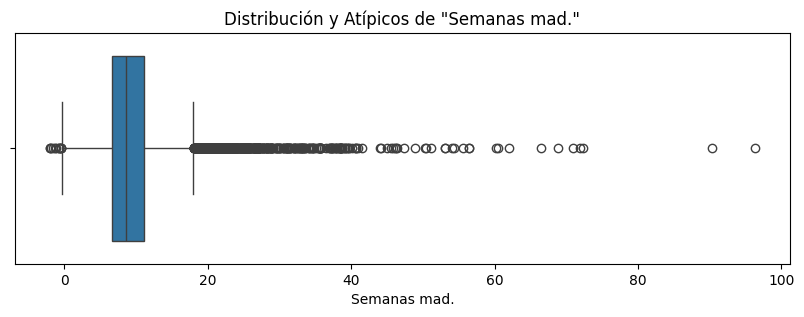



--- Análisis de 'Edad.Precosecha' ---
  - Asimetría (Skewness): -0.84
  - Media: 12.36
  - Mediana: 12.09


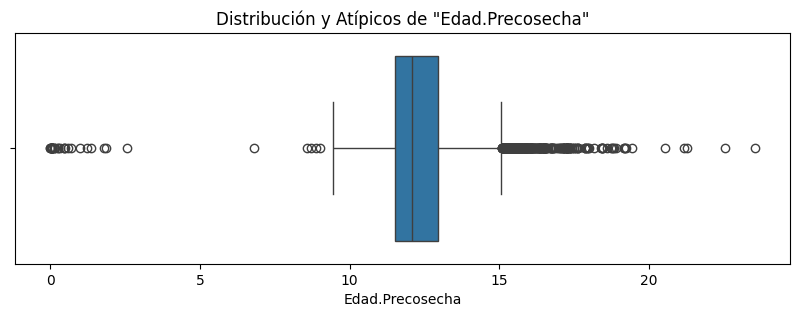



--- Análisis de '%AR Jugo' ---
  - Asimetría (Skewness): 1.18
  - Media: 0.74
  - Mediana: 0.70


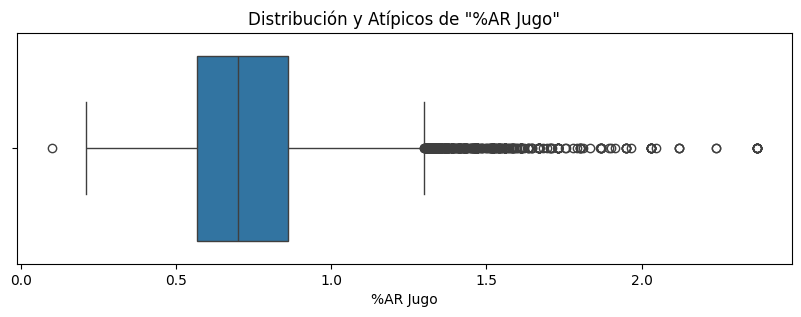



--- Análisis de 'Vejez' ---
  - Asimetría (Skewness): 2.90
  - Media: 12.29
  - Mediana: 2.74


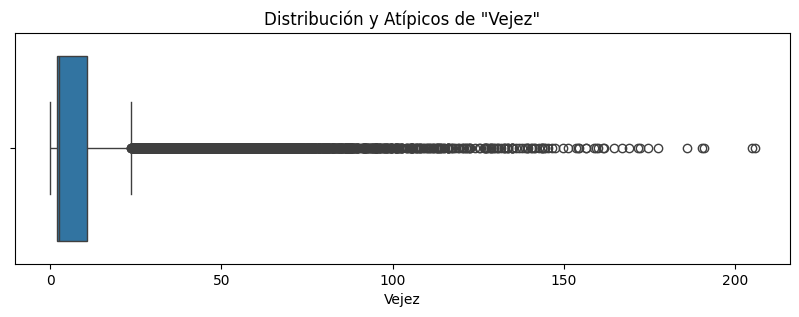



--- Análisis de 'Num.Riegos' ---
  - Asimetría (Skewness): 10.54
  - Media: 7.22
  - Mediana: 5.00


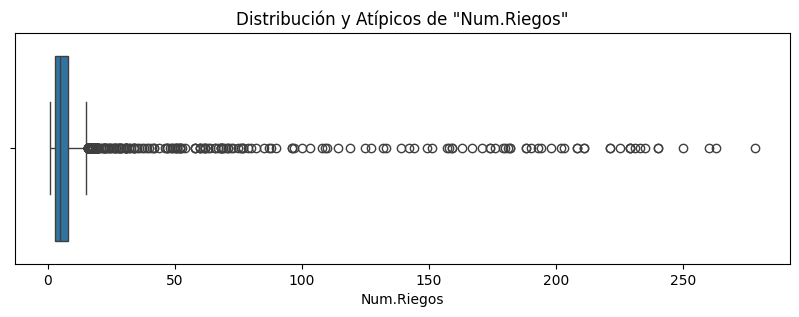



--- Análisis de '%Infest.Diatrea' ---
  - Asimetría (Skewness): 2.36
  - Media: 3.81
  - Mediana: 3.14


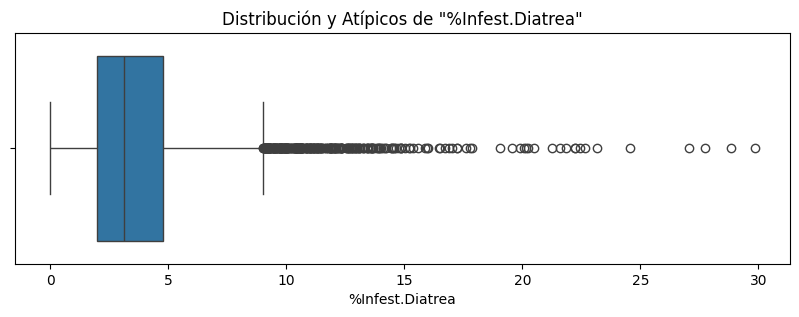

In [58]:
# Iteramos sobre cada columna para analizarla individualmente

columnas_fase2 = [
    col for col in total_columnas_fase2
    if df[col].dtype in ['int64', 'float64']
]

for columna in columnas_fase2:
    # --- Cálculo de estadísticas ---
    asimetria = df[columna].skew()
    media = df[columna].mean()
    mediana = df[columna].median()
    
    print(f"--- Análisis de '{columna}' ---")
    print(f"  - Asimetría (Skewness): {asimetria:.2f}")
    print(f"  - Media: {media:.2f}")
    print(f"  - Mediana: {mediana:.2f}")
    
    # --- Visualización del Boxplot ---
    plt.figure(figsize=(10, 3)) # Crea una figura nueva para cada gráfico
    sns.boxplot(x=df[columna])
    plt.title(f'Distribución y Atípicos de "{columna}"')
    plt.show() # Muestra el gráfico en la salida de la celda
    print("\n") # Agrega un espacio para mayor claridad

In [59]:
# Listas para clasificar las columnas
columnas_para_mediana = []
columnas_para_media = []

# Umbral de asimetría para decidir. Si |asimetría| > 1.0, se considera muy asimétrica.
umbral_asimetria = 1.0

# Clasificamos cada columna basándonos en su asimetría
for columna in columnas_fase2:
    asimetria = df[columna].skew()
    
    if abs(asimetria) > umbral_asimetria:
        columnas_para_mediana.append(columna)
    else:
        columnas_para_media.append(columna)

print("--- Clasificación Final para Imputación ---")
print(f"✅ Columnas a imputar con MEDIANA (distribución asimétrica):")
print(f"   {columnas_para_mediana}")
print(f"\n✅ Columnas a imputar con MEDIA (distribución simétrica):")
print(f"   {columnas_para_media}")

--- Clasificación Final para Imputación ---
✅ Columnas a imputar con MEDIANA (distribución asimétrica):
   ['Semanas mad.', '%AR Jugo', 'Vejez', 'Num.Riegos', '%Infest.Diatrea']

✅ Columnas a imputar con MEDIA (distribución simétrica):
   ['Edad.Precosecha']


In [60]:
# Imputar con la MEDIANA
if columnas_para_mediana:
    mediana_imputacion = df[columnas_para_mediana].median()
    df[columnas_para_mediana] = df[columnas_para_mediana].fillna(mediana_imputacion)
    print("-> Valores nulos imputados con la MEDIANA.")

# Imputar con la MEDIA
if columnas_para_media:
    media_imputacion = df[columnas_para_media].mean()
    df[columnas_para_media] = df[columnas_para_media].fillna(media_imputacion)
    print("-> Valores nulos imputados con la MEDIA.")


df[columnas_para_mediana].info()
df[columnas_para_media].info()

-> Valores nulos imputados con la MEDIANA.
-> Valores nulos imputados con la MEDIA.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Semanas mad.     21027 non-null  float64
 1   %AR Jugo         21027 non-null  float64
 2   Vejez            21027 non-null  float64
 3   Num.Riegos       21027 non-null  float64
 4   %Infest.Diatrea  21027 non-null  float64
dtypes: float64(5)
memory usage: 821.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Edad.Precosecha  21027 non-null  float64
dtypes: float64(1)
memory usage: 164.4 KB


#### Categoricas

--- Análisis de Distribución para: 'Suelo' ---
Conteo de valores (incluyendo nulos):
Suelo
CORINTIAS               4042
NaN                     3758
GALPON                  2282
PALMIRA                 1457
MANUELITA                742
NUEVO PICHICHI           599
CERRITO                  431
BURRIGA                  415
PALMERAS                 407
SANTA ROSA               336
RIO LA PAILA             285
GENOVA                   278
AMAIME                   272
JUANCHITO                239
GUADUAL                  236
BALLESTEROS              229
CERRITO-NIMA             227
JORDAN                   213
PALMICHE                 210
NIMA                     195
ESNEDA                   170
MARSELLA                 167
MARGARITA                158
TIBET                    156
GENOVEZ                  139
JAMAICA                  139
NARINO                   132
VILLA                    115
PALMIRITA                115
OVEJERA                  110
ESMERALDA                107
YUMBO     

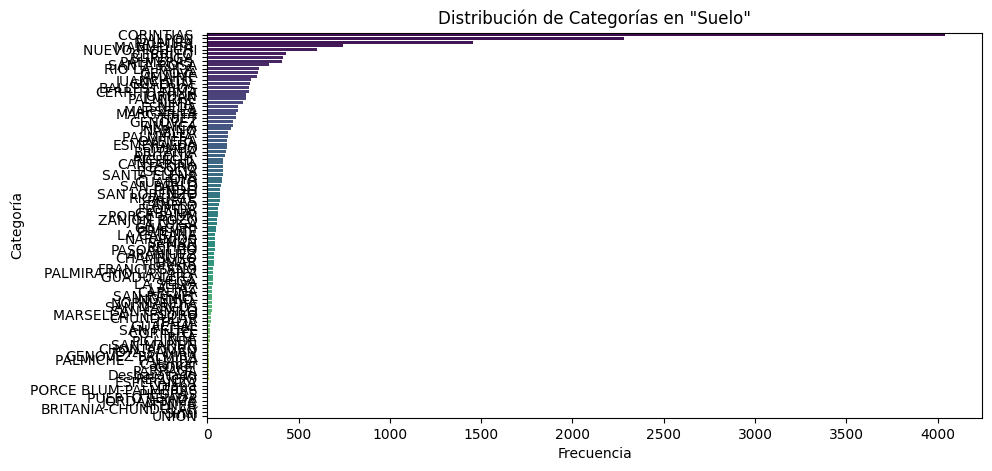



--- Análisis de Distribución para: 'D.S.' ---
Conteo de valores (incluyendo nulos):
D.S.
NaN     13859
1.65     7148
DS         19
1.5         1
Name: count, dtype: int64




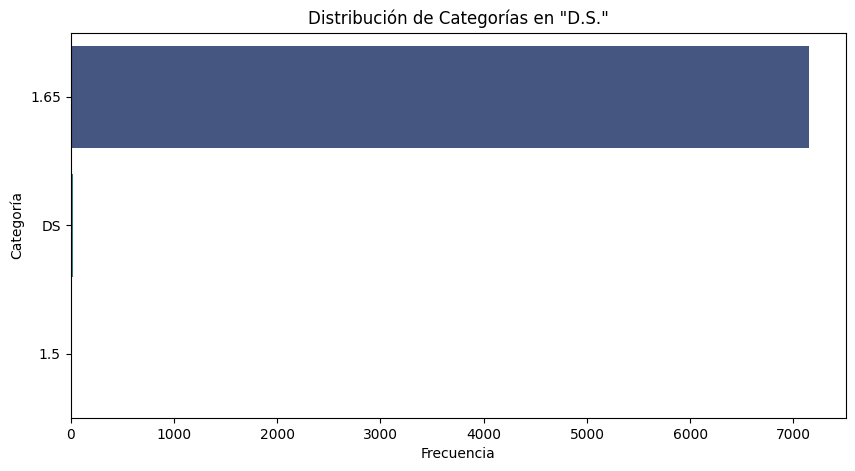



--- Análisis de Distribución para: 'Producto' ---
Conteo de valores (incluyendo nulos):
Producto
NaN                                      9778
BONUS 250 EC REGULADOR FISIOLÓGICO       7001
BONUS 250 EC REGULADOR FISIOLOGICO       3380
COADYUVANTE  DOUCE                        380
FERTILIZANTE LIQUIDO RENDIMIENTO          179
FUSILADE 2000 BL                           84
AGROFOSK-M                                 54
MADURANTE REGULADOR TRONNUSPAC 250 EC      36
FERTILIZANTE ORGÁNICO PATER-M              31
ROUND-UP MONSANTO 747 GRANULADO            29
baykal                                     22
PRODUCTO ENSAYO EN LITROS                  18
MADURANTE BIO SAFE ORGANIC                 17
TRANSLOK                                    7
OTROS MADURANTES                            4
GREEN LIFE                                  3
AMINA 2-4-D                                 2
HERBICIDA CLICK 40 SC                       1
GLIFOLAQ                                    1
Name: count, dtype: int64



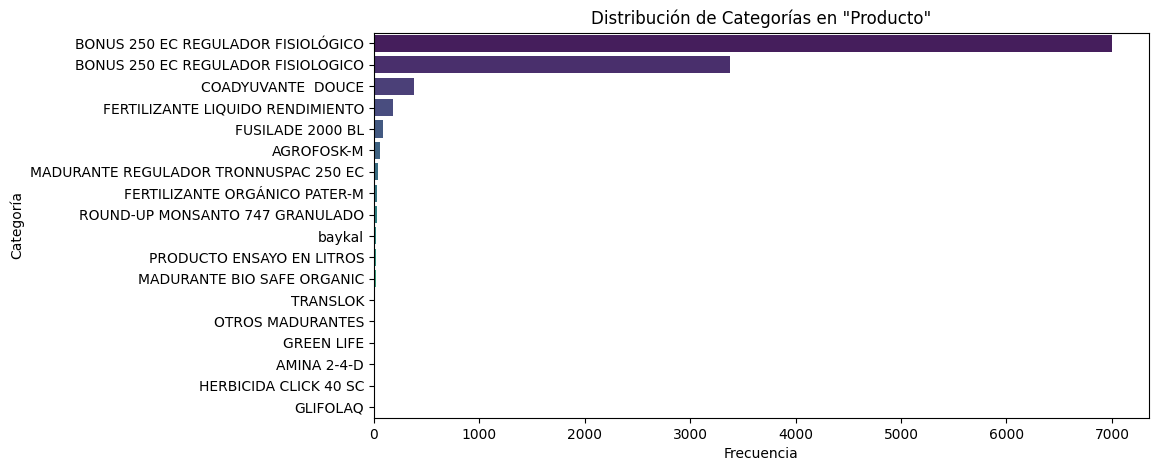



--- Análisis de Distribución para: 'Codigo Estacion' ---
Conteo de valores (incluyendo nulos):
Codigo Estacion
NaN    14742
999     1749
GUA      894
GIN      748
AMA      708
ROZ      641
MAR      318
YOT      310
AER      282
PLR      135
HON      110
PSJ       98
CAN       95
BUG       80
BLG       51
PTA       17
PRA       16
RIO       15
TUL       12
005        4
008        2
Name: count, dtype: int64




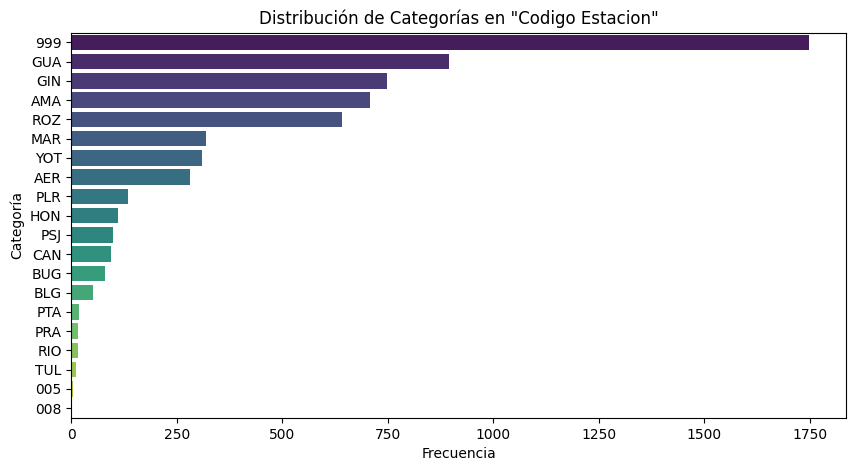

In [61]:
columnas_categoricas = [
    col for col in total_columnas_fase2
    if df[col].dtype == 'object'
]

for columna in columnas_categoricas:
    print(f"--- Análisis de Distribución para: '{columna}' ---")
    
    # Muestra el conteo de cada categoría, incluyendo los nulos (NaN)
    # Esto es clave para ver el panorama completo.
    print("Conteo de valores (incluyendo nulos):")
    print(df[columna].value_counts(dropna=False))
    print("\n")
    
    # Visualiza la distribución con un gráfico de barras (countplot)
    plt.figure(figsize=(10, 5))
    sns.countplot(y=df[columna], order=df[columna].value_counts().index, palette='viridis')
    plt.title(f'Distribución de Categorías en "{columna}"')
    plt.xlabel('Frecuencia')
    plt.ylabel('Categoría')
    plt.show() # Muestra el gráfico en la salida de la celda
    print("\n" + "="*50 + "\n")

##### Tratamiento de valores nulos en variables categóricas

Tras el análisis exploratorio, se identificaron varias columnas categóricas con valores nulos:

- **`Suelo`**: 18% nulos → imputado con la categoría *"Desconocido"*, ya que representa un atributo importante del lote y se evita perder información.
- **`D.S.`**: 66% nulos → eliminada. Su naturaleza poco clara por su ausencia en el diccionario de datos y la falta de estandarización hacen que aporte más ruido que valor.
- **`Producto`**: 46% nulos → imputado con *"No aplicado"*, dado que los nulos reflejan la ausencia de uso de madurante, lo cual es información relevante.
- **`Codigo Estacion`**: 70% nulos → eliminada. La información climática ya está representada en variables más robustas (lluvia, temperatura, humedad).
- **`Cerca de`**: <1% nulos → eliminada. Es redundante frente a otras variables geográficas como *Zona* o *Dist Km*.
- **`Cultivo`**: <0.01% nulos → imputado con *"Desconocido"* debido a la baja proporción de faltantes.

Con estas transformaciones, el dataset queda libre de nulos tanto en variables numéricas como categóricas, permitiendo avanzar hacia el desarrollo de los modelos de regresión y clasificación.


In [62]:
# Imputaciones directamente sobre df
df['Suelo'] = df['Suelo'].fillna("Desconocido")
df['Producto'] = df['Producto'].fillna("No aplicado")
df['Cultivo'] = df['Cultivo'].fillna("Desconocido")

# Eliminaciones
df = df.drop(columns=['D.S.', 'Codigo Estacion', 'Cerca de'])

# Verificación final
print("Nulos restantes por columna:")
print(df.isnull().sum().sort_values(ascending=False).head(15))

Nulos restantes por columna:
Ult.Riego              12557
Fec.Madur.              9775
Fosfato Jugo            1858
%Sac.Muestreadora       1858
%Fibra Caña             1858
%ME Min                 1722
%ME Tot                 1720
%ME Veg                 1720
Sac.Caña Precosecha     1098
KATRHM                   522
%ATR                     522
%Sac.Caña                449
Pureza                   269
Brix                     267
Rdto                     267
dtype: int64


---

#### **Fase 3: Imputación Simple o Eliminación de Filas (< 10% de Nulos)**
Finalmente, las columnas con un bajo porcentaje de datos faltantes (< 10%), como `Dist Km`, `Ton.Azucar`, y `Rdto`, son las más sencillas de tratar. El impacto de la imputación o eliminación es mínimo.

* **Acción:** Para estas variables, se utilizará una imputación por la **media** (si la distribución es simétrica) o la **mediana**. Dado el bajo número de filas afectadas, la **eliminación directa de los registros** que contienen estos nulos es también una opción viable y limpia que se considerará.

El objetivo de este plan es limpiar y consolidar el dataset de manera metódica, maximizando la retención de información útil mientras se asegura la robustez y fiabilidad de los datos para el modelado predictivo.

In [63]:
# Calcular el umbral del 10%
total_filas = len(df)
umbral_10_porciento = total_filas * 0.10

# Filtrar columnas numéricas con nulos por debajo del umbral
columnas_fase3 = [
    col for col in df.columns
    if (df[col].isnull().sum() > 0) and \
       (df[col].isnull().sum() < umbral_10_porciento) and \
       (df[col].dtype in ['int64', 'float64'])
]

if not columnas_fase3:
    print("🎉 ¡No hay columnas numéricas con menos del 10% de nulos por tratar!")
else:
    print(f"Se analizarán {len(columnas_fase3)} columnas en la Fase 3:")
    df[columnas_fase3].info()

Se analizarán 20 columnas en la Fase 3:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tenencia             21026 non-null  float64
 1   Dist Km              21022 non-null  float64
 2   Cod. T.Cultivo       21025 non-null  float64
 3   Dosis Madurante      20923 non-null  float64
 4   Ton.Azucar           20786 non-null  float64
 5   Rdto                 20760 non-null  float64
 6   TAH                  20786 non-null  float64
 7   TAHM                 20786 non-null  float64
 8   Sac.Caña Precosecha  19929 non-null  float64
 9   %Sac.Caña            20578 non-null  float64
 10  %Sac.Muestreadora    19169 non-null  float64
 11  %ATR                 20505 non-null  float64
 12  KATRHM               20505 non-null  float64
 13  %Fibra Caña          19169 non-null  float64
 14  %ME Min              19305 non-null  float64
 

--- Análisis de 'Tenencia' ---
  - Nulos: 1 (0.00%)
  - Asimetría (Skewness): 0.04
  - Media: 46.45
  - Mediana: 51.00


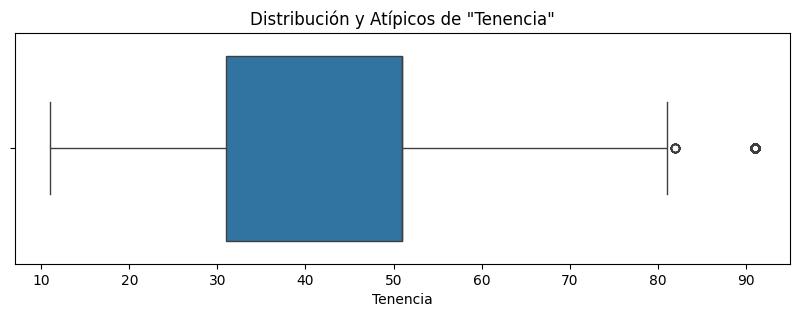



--- Análisis de 'Dist Km' ---
  - Nulos: 5 (0.02%)
  - Asimetría (Skewness): 1.81
  - Media: 25.31
  - Mediana: 21.90


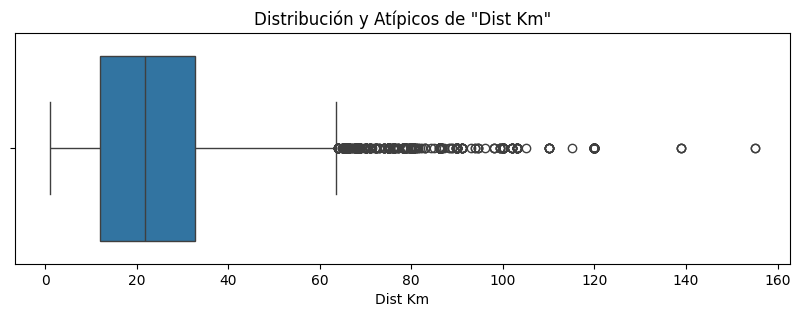



--- Análisis de 'Cod. T.Cultivo' ---
  - Nulos: 2 (0.01%)
  - Asimetría (Skewness): 4.97
  - Media: 1.04
  - Mediana: 1.00


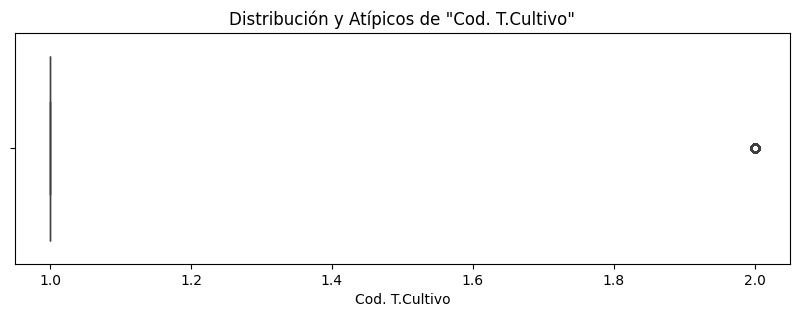



--- Análisis de 'Dosis Madurante' ---
  - Nulos: 104 (0.49%)
  - Asimetría (Skewness): 0.34
  - Media: 0.54
  - Mediana: 0.60


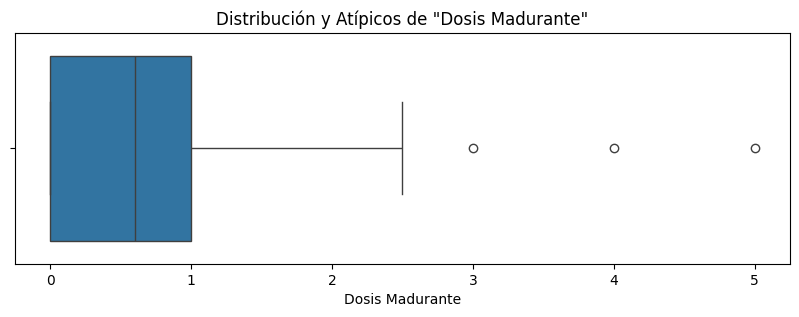



--- Análisis de 'Ton.Azucar' ---
  - Nulos: 241 (1.15%)
  - Asimetría (Skewness): 1.75
  - Media: 124.25
  - Mediana: 93.74


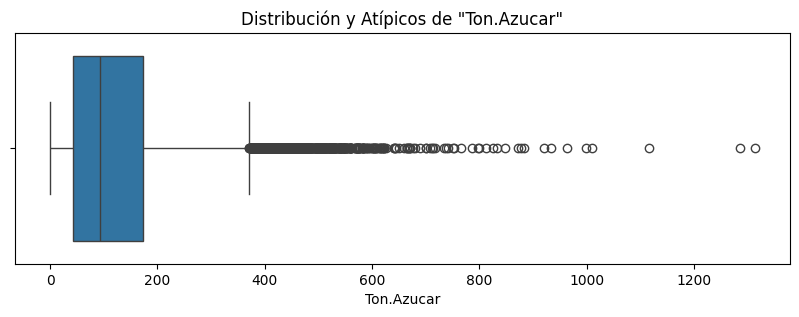



--- Análisis de 'Rdto' ---
  - Nulos: 267 (1.27%)
  - Asimetría (Skewness): -3.20
  - Media: 10.73
  - Mediana: 10.89


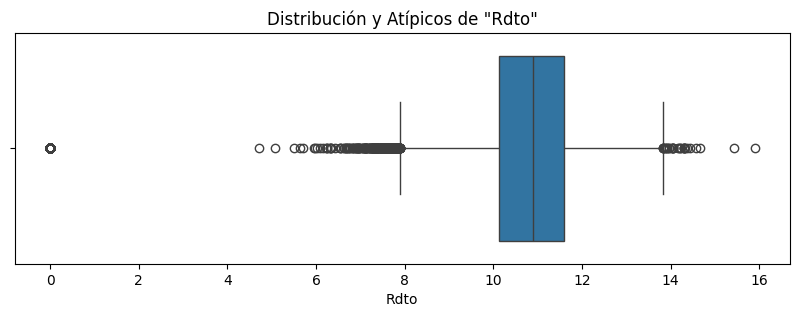



--- Análisis de 'TAH' ---
  - Nulos: 241 (1.15%)
  - Asimetría (Skewness): -0.18
  - Media: 13.89
  - Mediana: 14.01


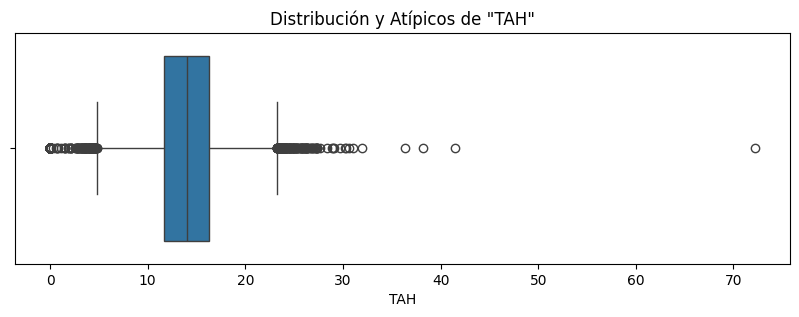



--- Análisis de 'TAHM' ---
  - Nulos: 241 (1.15%)
  - Asimetría (Skewness): -0.20
  - Media: 1.07
  - Mediana: 1.09


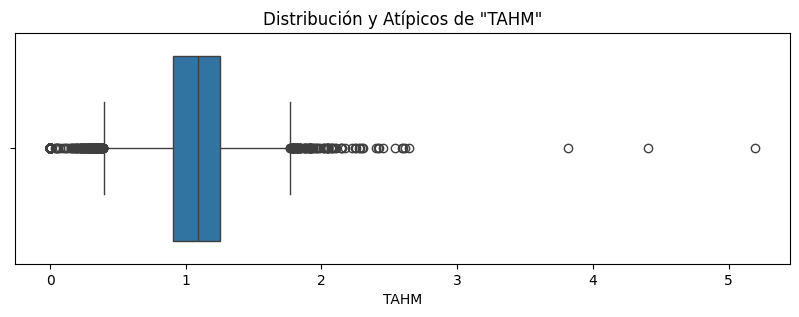



--- Análisis de 'Sac.Caña Precosecha' ---
  - Nulos: 1098 (5.22%)
  - Asimetría (Skewness): 0.20
  - Media: 7.80
  - Mediana: 0.00


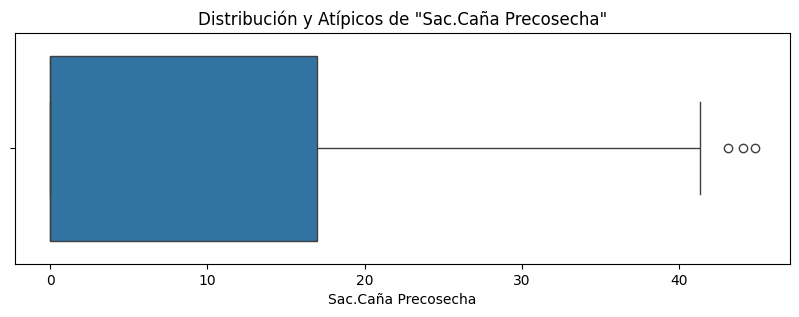



--- Análisis de '%Sac.Caña' ---
  - Nulos: 449 (2.14%)
  - Asimetría (Skewness): -0.26
  - Media: 12.32
  - Mediana: 12.37


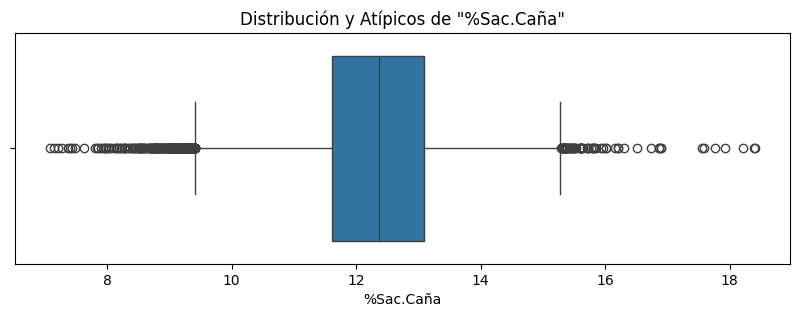



--- Análisis de '%Sac.Muestreadora' ---
  - Nulos: 1858 (8.84%)
  - Asimetría (Skewness): -3.65
  - Media: 12.83
  - Mediana: 13.05


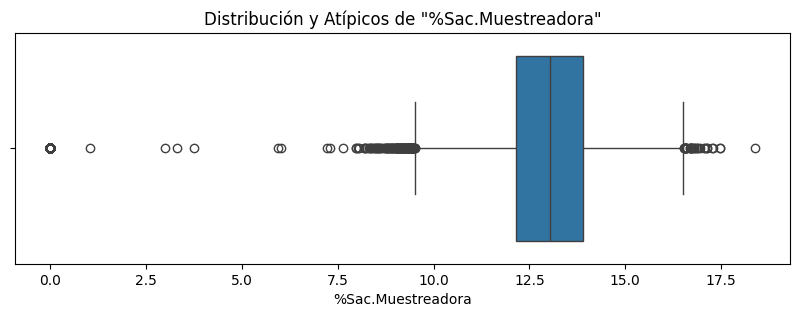



--- Análisis de '%ATR' ---
  - Nulos: 522 (2.48%)
  - Asimetría (Skewness): 35.51
  - Media: 13.72
  - Mediana: 13.75


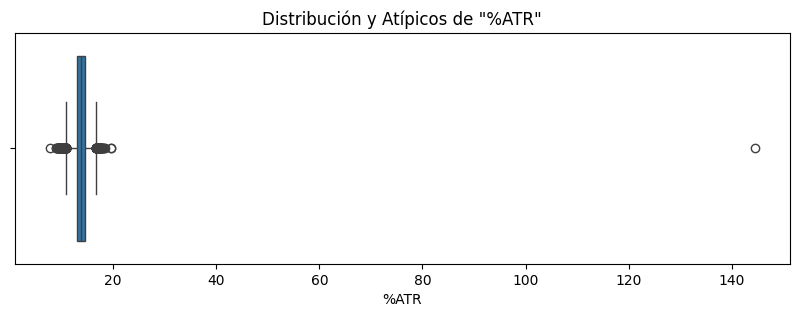



--- Análisis de 'KATRHM' ---
  - Nulos: 522 (2.48%)
  - Asimetría (Skewness): 3.39
  - Media: 1372.45
  - Mediana: 1383.49


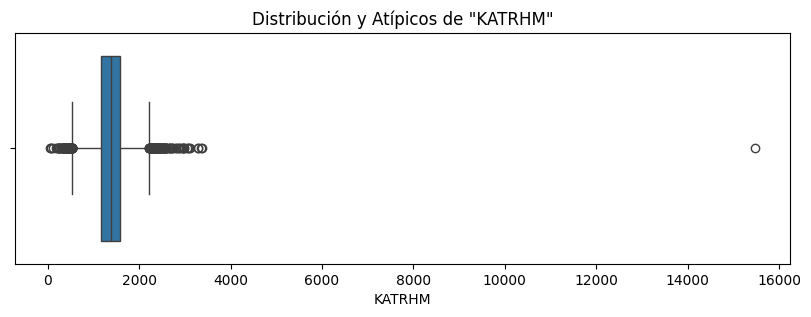



--- Análisis de '%Fibra Caña' ---
  - Nulos: 1858 (8.84%)
  - Asimetría (Skewness): -2.76
  - Media: 15.28
  - Mediana: 15.31


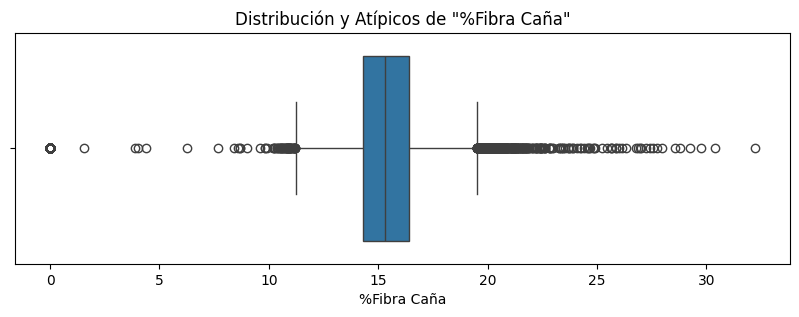



--- Análisis de '%ME Min' ---
  - Nulos: 1722 (8.19%)
  - Asimetría (Skewness): 4.28
  - Media: 0.64
  - Mediana: 0.34


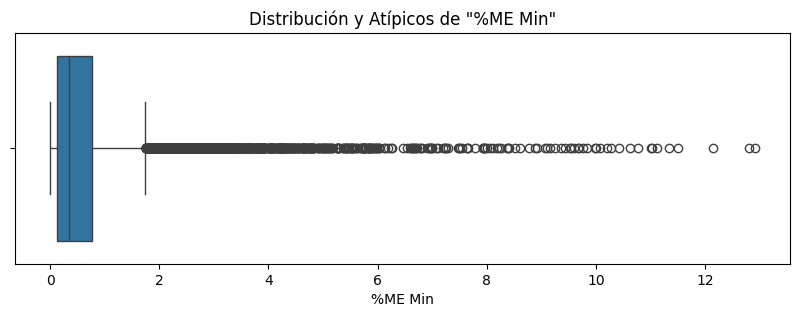



--- Análisis de '%ME Veg' ---
  - Nulos: 1720 (8.18%)
  - Asimetría (Skewness): 21.55
  - Media: 7.76
  - Mediana: 8.09


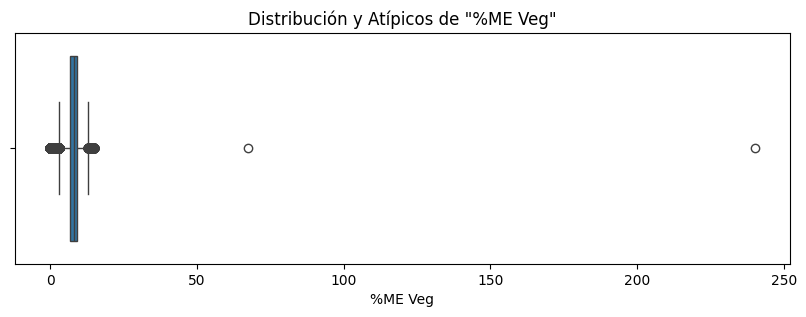



--- Análisis de '%ME Tot' ---
  - Nulos: 1720 (8.18%)
  - Asimetría (Skewness): 0.48
  - Media: 8.60
  - Mediana: 8.67


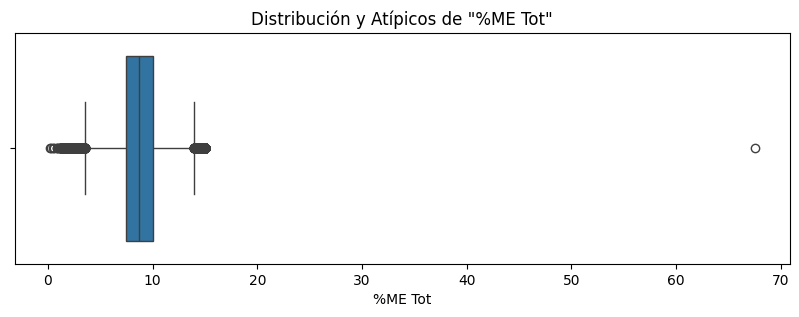



--- Análisis de 'Brix' ---
  - Nulos: 267 (1.27%)
  - Asimetría (Skewness): -2.58
  - Media: 13.13
  - Mediana: 14.31


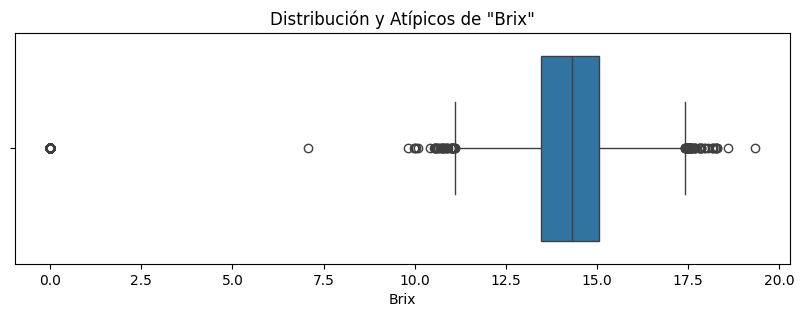



--- Análisis de 'Pureza' ---
  - Nulos: 269 (1.28%)
  - Asimetría (Skewness): -2.83
  - Media: 77.81
  - Mediana: 85.53


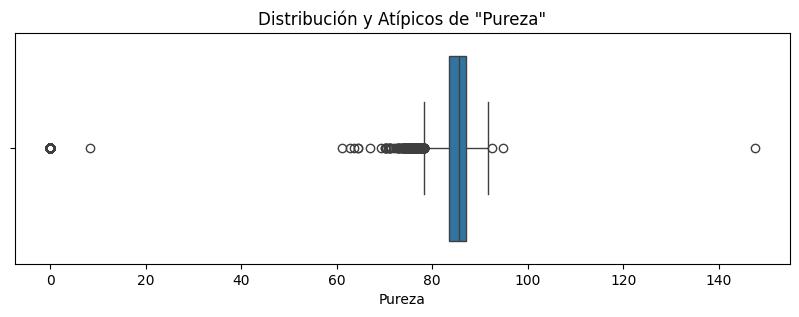



--- Análisis de 'Fosfato Jugo' ---
  - Nulos: 1858 (8.84%)
  - Asimetría (Skewness): 74.03
  - Media: 332.50
  - Mediana: 289.00


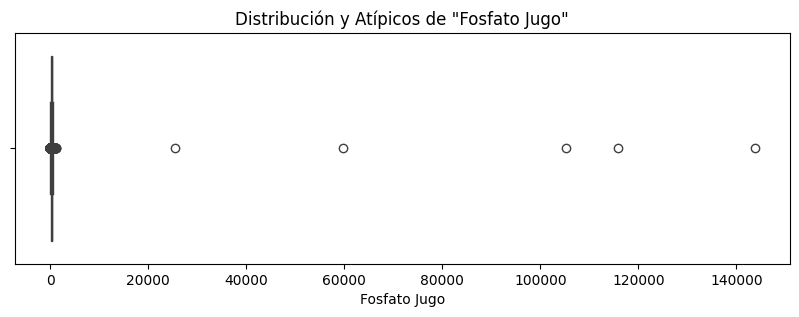

In [64]:
# Iteramos sobre cada columna identificada para la Fase 3
for columna in columnas_fase3:
    # --- Cálculo de estadísticas ---
    asimetria = df[columna].skew()
    media = df[columna].mean()
    mediana = df[columna].median()
    
    print(f"--- Análisis de '{columna}' ---")
    print(f"  - Nulos: {df[columna].isnull().sum()} ({df[columna].isnull().sum() / len(df) * 100:.2f}%)")
    print(f"  - Asimetría (Skewness): {asimetria:.2f}")
    print(f"  - Media: {media:.2f}")
    print(f"  - Mediana: {mediana:.2f}")
    
    # --- Visualización del Boxplot ---
    plt.figure(figsize=(10, 3)) # Crea una figura nueva para cada gráfico
    sns.boxplot(x=df[columna])
    plt.title(f'Distribución y Atípicos de "{columna}"')
    plt.show() # Muestra el gráfico en la salida de la celda
    print("\n") # Agrega un espacio para mayor claridad

In [65]:
# Listas para clasificar las columnas
columnas_para_mediana_f3 = []
columnas_para_media_f3 = []

# Umbral de asimetría para decidir
umbral_asimetria = 1.0

# Clasificamos cada columna basándonos en su asimetría
for columna in columnas_fase3:
    asimetria = df[columna].skew()
    
    if abs(asimetria) > umbral_asimetria:
        columnas_para_mediana_f3.append(columna)
    else:
        columnas_para_media_f3.append(columna)

print("--- Clasificación Final para Imputación (Fase 3) ---")
print(f"✅ Columnas a imputar con MEDIANA (distribución asimétrica):")
print(f"   {columnas_para_mediana_f3}")
print(f"\n✅ Columnas a imputar con MEDIA (distribución simétrica):")
print(f"   {columnas_para_media_f3}")

--- Clasificación Final para Imputación (Fase 3) ---
✅ Columnas a imputar con MEDIANA (distribución asimétrica):
   ['Dist Km', 'Cod. T.Cultivo', 'Ton.Azucar', 'Rdto', '%Sac.Muestreadora', '%ATR', 'KATRHM', '%Fibra Caña', '%ME Min', '%ME Veg', 'Brix', 'Pureza', 'Fosfato Jugo']

✅ Columnas a imputar con MEDIA (distribución simétrica):
   ['Tenencia', 'Dosis Madurante', 'TAH', 'TAHM', 'Sac.Caña Precosecha', '%Sac.Caña', '%ME Tot']


In [66]:
# Imputar con la MEDIANA
if columnas_para_mediana_f3:
    mediana_imputacion = df[columnas_para_mediana_f3].median()
    df[columnas_para_mediana_f3] = df[columnas_para_mediana_f3].fillna(mediana_imputacion)
    print("-> Valores nulos imputados con la MEDIANA.")

# Imputar con la MEDIA
if columnas_para_media_f3:
    media_imputacion = df[columnas_para_media_f3].mean()
    df[columnas_para_media_f3] = df[columnas_para_media_f3].fillna(media_imputacion)
    print("-> Valores nulos imputados con la MEDIA.")

df[columnas_para_mediana_f3].info()
df[columnas_para_media_f3].info()


-> Valores nulos imputados con la MEDIANA.
-> Valores nulos imputados con la MEDIA.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dist Km            21027 non-null  float64
 1   Cod. T.Cultivo     21027 non-null  float64
 2   Ton.Azucar         21027 non-null  float64
 3   Rdto               21027 non-null  float64
 4   %Sac.Muestreadora  21027 non-null  float64
 5   %ATR               21027 non-null  float64
 6   KATRHM             21027 non-null  float64
 7   %Fibra Caña        21027 non-null  float64
 8   %ME Min            21027 non-null  float64
 9   %ME Veg            21027 non-null  float64
 10  Brix               21027 non-null  float64
 11  Pureza             21027 non-null  float64
 12  Fosfato Jugo       21027 non-null  float64
dtypes: float64(13)
memory usage: 2.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeInd

### RE-CHEQUEO Datos nulos

In [67]:
# 1. Identifica las variables o columnas en el dataset con valores nulos
columnas_con_nulos = [
    (columna, df[columna].isnull().sum())
    for columna in df.columns
    if df[columna].isnull().sum() > 0
]
# 2. Convertir la lista a un DataFrame de pandas para una mejor visualización
df_nulos = pd.DataFrame(columnas_con_nulos, columns=['Columna', 'Cantidad de Nulos'])

# Ordenar los resultados de mayor a menor
df_nulos_ordenado = df_nulos.sort_values(by='Cantidad de Nulos', ascending=False)


# Imprimir el DataFrame resultante
print("\nResultados en una tabla ordenada de mayor a menor:")
df_nulos_ordenado


Resultados en una tabla ordenada de mayor a menor:


,Columna,Cantidad de Nulos
0,Ult.Riego,12557
1,Fec.Madur.,9775


#### Tratamiento de columnas de fecha con valores nulos

En el análisis final de nulos se identificaron dos columnas con una alta proporción de valores faltantes:

- **`Ult.Riego`** → 12,557 nulos (~60%)
- **`Fec.Madur.`** → 9,775 nulos (~46%)

Ambas variables corresponden a **fechas** (`datetime`). Aunque en teoría podrían transformarse en variables derivadas (por ejemplo, *días desde el último riego* o *días hasta la madurez*), presentan dos limitaciones importantes:

1. **Alto porcentaje de nulos**: más del 40% de los registros carecen de esta información, lo que implicaría una imputación masiva y poco confiable.
2. **Complejidad de integración**: para ser útiles en un modelo de regresión, las fechas deben convertirse en variables numéricas. Sin embargo, la heterogeneidad en los registros y la cantidad de valores faltantes dificultan la generación de indicadores consistentes.

Por estos motivos, se decidió **eliminar ambas columnas del dataset**. Esta decisión mantiene la integridad del conjunto de datos y evita introducir sesgos o ruido en el modelo. En fases posteriores, si se cuenta con información más completa, podrían explorarse variables derivadas relacionadas con el riego y la maduración.

In [68]:
# Eliminamos columnas de fechas con demasiados nulos
df = df.drop(columns=['Ult.Riego', 'Fec.Madur.'])

# Verificación final de nulos
print("Nulos restantes por columna:")
print(df.isnull().sum().sort_values(ascending=False).head(15))


Nulos restantes por columna:
Período              0
Hacienda             0
%Sac.Caña            0
%Sac.Muestreadora    0
%ATR                 0
KATRHM               0
%Fibra Caña          0
%AR Jugo             0
%ME Min              0
%ME Veg              0
%ME Tot              0
Brix                 0
Pureza               0
Vejez                0
Tipo Quema           0
dtype: int64


Además de `Ult.Riego` y `Fec.Madur.`, se identificaron dos variables adicionales de tipo fecha:
- **`F.Siembra`** (fecha de siembra)
- **`F.Ult.Corte`** (fecha del último corte)

Ambas fueron eliminadas por las siguientes razones:
1. Los modelos de regresión lineal no pueden trabajar directamente con variables de tipo fecha.
2. La información que podrían aportar ya está representada en variables numéricas derivadas, como `Edad Ult Cos`, `Edad.Precosecha` y `Período`.
3. Mantenerlas sin transformar no aportaría valor predictivo y aumentaría la complejidad innecesaria del dataset.

Con esta decisión, el dataset final queda compuesto únicamente por variables numéricas y categóricas ya tratadas, lo que asegura consistencia para el modelado.

In [69]:
# Eliminamos columnas de fecha que no serán transformadas
df = df.drop(columns=['F.Siembra', 'F.Ult.Corte'])

print("Columnas finales después de eliminar fechas:")
print(df.columns.tolist())

Columnas finales después de eliminar fechas:
['Período', 'Hacienda', 'Nombre', 'Zona', 'Tenencia', 'Suerte', 'Suelo', 'Area Neta', 'Dist Km', 'Variedad', 'Cod.Estado #', 'Cod.Estado', 'Edad Ult Cos', 'Destino 1=Semilla', 'Cod. T.Cultivo', 'Cultivo', 'Producto', 'Dosis Madurante', 'Semanas mad.', 'TonUltCorte', 'TCH', 'TCHM', 'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'Sac.Caña Precosecha', 'Edad.Precosecha', '%Sac.Caña', '%Sac.Muestreadora', '%ATR', 'KATRHM', '%Fibra Caña', '%AR Jugo', '%ME Min', '%ME Veg', '%ME Tot', 'Brix', 'Pureza', 'Vejez', 'Tipo Quema', 'T.Corte', 'Cosechó', 'Num.Riegos', 'M3 Riego', 'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Fosfato Jugo']


### Analisis Bivariado

In [70]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("\nVariables Numéricas:", numerical_cols)
print("Variables Categóricas:", categorical_cols)


Variables Numéricas: ['Período', 'Hacienda', 'Tenencia', 'Area Neta', 'Dist Km', 'Cod.Estado #', 'Edad Ult Cos', 'Destino 1=Semilla', 'Cod. T.Cultivo', 'Dosis Madurante', 'Semanas mad.', 'TonUltCorte', 'TCH', 'TCHM', 'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'Sac.Caña Precosecha', 'Edad.Precosecha', '%Sac.Caña', '%Sac.Muestreadora', '%ATR', 'KATRHM', '%Fibra Caña', '%AR Jugo', '%ME Min', '%ME Veg', '%ME Tot', 'Brix', 'Pureza', 'Vejez', 'Num.Riegos', 'M3 Riego', 'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Fosfato Jugo']
Variables Categóricas: ['Nombre', 'Zona', 'Suerte', 'Suelo', 'Variedad', 'Cod.Estado', 'Cultivo', 'Producto', 'Tipo Quema', 'T.Corte', 'Cosechó']


#### Matriz de correlación

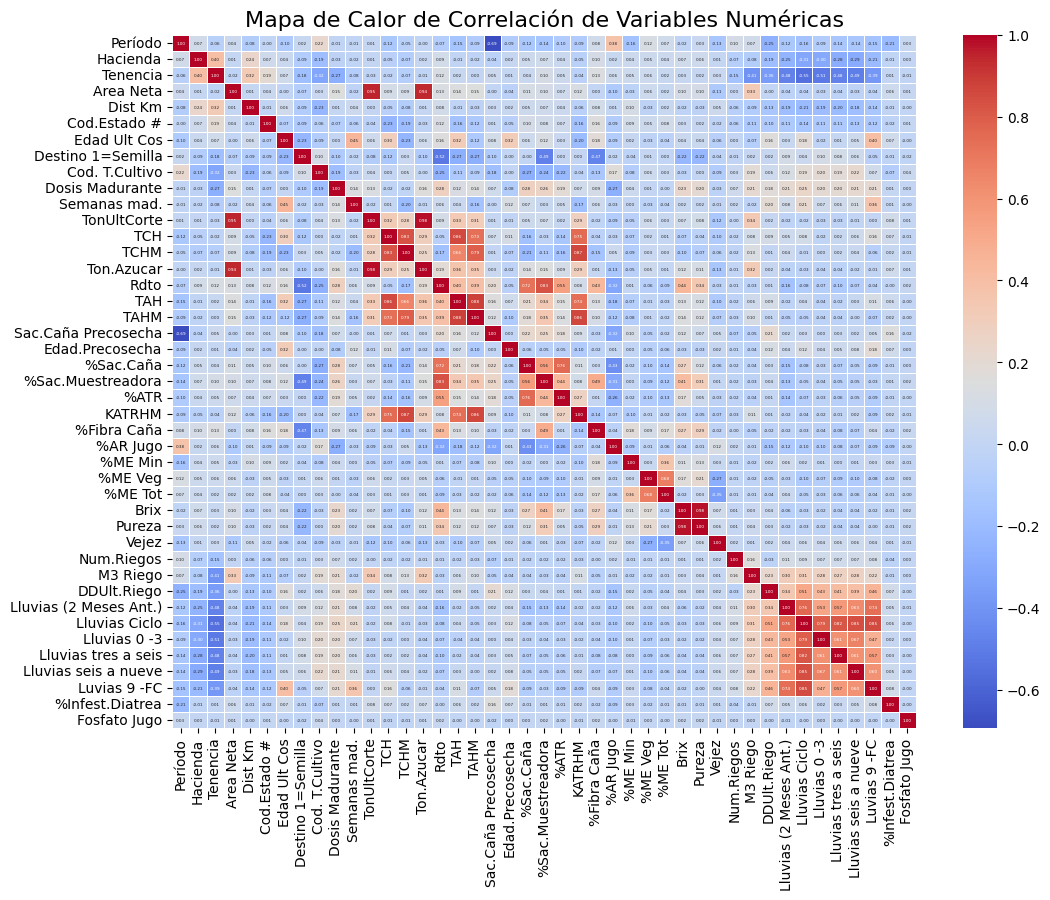

In [71]:
# Calcular la matriz de correlación
correlation_matrix = df[numerical_cols].corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 9))

# Crear el mapa de calor con Seaborn
sns.heatmap(
    correlation_matrix,
    annot=True,          # Mostrar los valores de correlación en las celdas
    cmap='coolwarm',     # Esquema de colores
    fmt=".2f",           # Formato de los números (2 decimales)
    linewidths=.5,
    annot_kws={'size': 3}
)

plt.title('Mapa de Calor de Correlación de Variables Numéricas', fontsize=16)
plt.show()

#### Optimización de la Matriz de Correlación

La matriz de correlación inicial, que incluía todas las variables numéricas, resultó ser demasiado densa para una interpretación efectiva debido a la alta dimensionalidad del dataset.

Para optimizar el análisis, se implementó un filtrado para seleccionar únicamente las variables que presentaban una correlación sustancial (valor absoluto > 0.5) con al menos otra variable.

La generación de un segundo mapa de calor con este subconjunto de variables permite una visualización más clara y eficiente que centra el análisis en las interrelaciones de mayor relevancia estadística, facilitando la detección de patrones y la identificación de multicolinealidad para el modelado predictivo.
De igual manera, para efectos practicos se deja el grafico anterior completo en caso de querer observar relaciones que pudieron desaparecer con el filtro aplicado

Variables originales: ['Período', 'Hacienda', 'Tenencia', 'Area Neta', 'Dist Km', 'Cod.Estado #', 'Edad Ult Cos', 'Destino 1=Semilla', 'Cod. T.Cultivo', 'Dosis Madurante', 'Semanas mad.', 'TonUltCorte', 'TCH', 'TCHM', 'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'Sac.Caña Precosecha', 'Edad.Precosecha', '%Sac.Caña', '%Sac.Muestreadora', '%ATR', 'KATRHM', '%Fibra Caña', '%AR Jugo', '%ME Min', '%ME Veg', '%ME Tot', 'Brix', 'Pureza', 'Vejez', 'Num.Riegos', 'M3 Riego', 'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Fosfato Jugo']
Variables con correlaciones fuertes (>0.5): ['Período', 'Tenencia', 'Area Neta', 'Destino 1=Semilla', 'TonUltCorte', 'TCH', 'TCHM', 'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'Sac.Caña Precosecha', '%Sac.Caña', '%Sac.Muestreadora', '%ATR', 'KATRHM', '%ME Veg', '%ME Tot', 'Brix', 'Pureza', 'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias

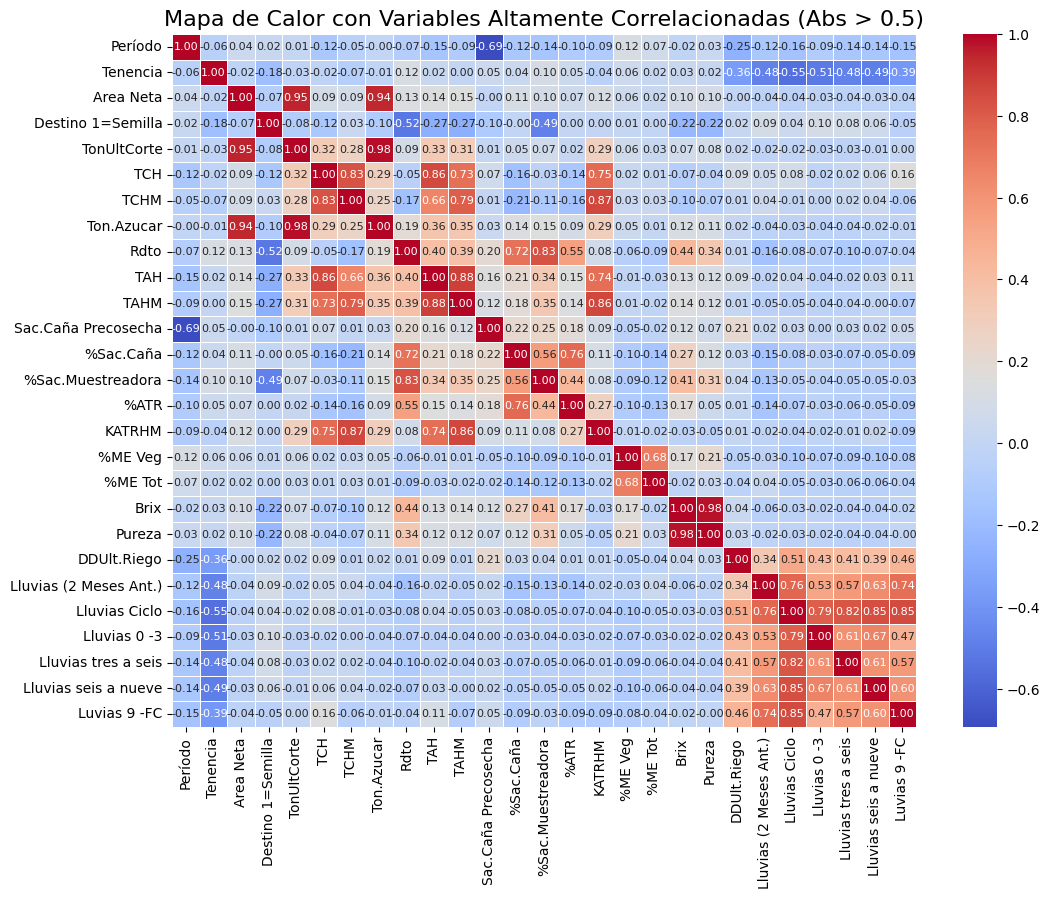

In [72]:
correlation_matrix_full = df[numerical_cols].corr()

abs_corr_matrix = correlation_matrix_full.abs()
np.fill_diagonal(abs_corr_matrix.values, 0)

has_strong_correlation = (abs_corr_matrix > 0.5).any()
cols_to_keep = has_strong_correlation[has_strong_correlation].index.tolist()

print(f"Variables originales: {numerical_cols}")
print(f"Variables con correlaciones fuertes (>0.5): {cols_to_keep}")

df_filtered = df[cols_to_keep]
correlation_matrix_filtered = df_filtered.corr()

plt.figure(figsize=(12, 9))

sns.heatmap(
    correlation_matrix_filtered,
    annot=True,          
    cmap='coolwarm',     
    fmt=".2f",           
    linewidths=.5,
    annot_kws={'size': 8}
)

plt.title('Mapa de Calor con Variables Altamente Correlacionadas (Abs > 0.5)', fontsize=16)
plt.show()

#### Análisis Detallado de Correlaciones Fuertes

A continuación se realizara un analisis que desglosa las relaciones estadísticas para traducirlas en conocimiento agronómico y operativo, con un enfoque claro en los objetivos de predecir **TCH** y **%Sac.Caña**.

##### 1. Correlaciones de Producción y Tamaño del Lote

Estas correlaciones son las más fuertes y, en su mayoría, confirman la consistencia y lógica de los datos.

* `Area Neta y TonUltCorte: 0.95`
* `Area Neta y Ton.Azucar: 0.94`
* `TonUltCorte y Ton.Azucar: 0.98`

**Análisis Detallado:**

* **Interpretación:** Estas correlaciones son casi perfectas y reflejan una relación casi determinista. `TonUltCorte` (Toneladas totales del último corte) es el producto del rendimiento (`TCH`) y el `Area Neta`. Por lo tanto, a mayor área, es lógico esperar una mayor producción total de caña. De manera similar, `Ton.Azucar` es el resultado de multiplicar las toneladas de caña (`TonUltCorte`) por el rendimiento industrial (`Rdto`).
* **Significado Agronómico:** Esto valida la integridad de los datos. Si un lote más grande no produjera más toneladas de caña y azúcar, existiria un serio problema de medición o registro.
* **Implicaciones para el Modelo de ML:**
    * Estas variables no deben usarse como predictoras directas para `TCH`. Por ejemplo, `TonUltCorte` se calcula a partir de `TCH` (`TCH = TonUltCorte / Area Neta`). Usar `TonUltCorte` o `Area Neta` para predecir `TCH` sería un error, ya que el modelo aprendería una simple fórmula matemática en lugar de patrones agronómicos complejos.
    * Son variables de resultado, no de proceso. Sirven para calcular los KPIs finales, pero no explican *por qué* un lote tuvo un rendimiento específico.

---

##### 2. Correlaciones entre Métricas de Rendimiento (Productividad)

Este grupo muestra cómo las diferentes formas de medir la productividad agrícola e industrial están interrelacionadas.

* `TCH y TCHM: 0.83`
* `TCH y TAH: 0.86`
* `TCH y TAHM: 0.73`
* `TCH y KATRHM: 0.75`
* `TCHM y TAH: 0.66`
* `TCHM y TAHM: 0.79`
* `TCHM y KATRHM: 0.87`
* `TAH y TAHM: 0.88`
* `TAH y KATRHM: 0.74`
* `TAHM y KATRHM: 0.86`

*(Suposición de acrónimos: TCHM = TCH Medido/Muestreado, TAH = Toneladas de Azúcar por Hectárea, TAHM = TAH Medido/Muestreado, KATRHM = Kilos de ATR por Hectárea Medido)*

**Análisis Detallado:**

* **Interpretación:** Existe una fuerte consistencia entre todas las métricas de rendimiento por hectárea. `TCH` (Toneladas de Caña/Ha) es la base. `TAH` (Toneladas de Azúcar/Ha) es probablemente el resultado de multiplicar `TCH` por la calidad (`Rdto` o `%Sac.Caña`). Por lo tanto, un `TCH` alto generalmente conduce a un `TAH` alto, a menos que la calidad de la caña sea excepcionalmente baja.
* **Significado Agronómico:** Estas correlaciones demuestran que, en general, los factores que favorecen un alto volumen de biomasa (caña) también favorecen una alta producción de azúcar por superficie. El objetivo agronómico es maximizar ambos simultáneamente. La correlación `TCHM y KATRHM: 0.87` es particularmente fuerte, indicando que las mediciones de campo (muestreadas) son muy buen indicativo del rendimiento final de azúcares recuperables.
* **Implicaciones para el Modelo de ML:**
    * Al igual que en el punto anterior, estas variables son **variables objetivo o derivadas del objetivo**. No se pueden usar como predictoras entre sí para explicar las causas del rendimiento. Por ejemplo, no se puede usar `TAH` para predecir `TCH`.
    * La elección de la variable objetivo principal (`TCH`) es correcta. Las otras son métricas de resultado que se pueden calcular posteriormente o modelar por separado si es necesario.

---

##### 3. Correlaciones entre Métricas de Calidad del Jugo y Rendimiento Industrial

Este grupo es crucial para entender los predictores de la segunda variable objetivo: `%Sac.Caña`.

* `Rdto y %Sac.Caña: 0.72`
* `Rdto y %Sac.Muestreadora: 0.83`
* `Rdto y %ATR: 0.55`
* `%Sac.Caña y %Sac.Muestreadora: 0.56`
* `%Sac.Caña y %ATR: 0.76`
* `Brix y Pureza: 0.98`

**Análisis Detallado:**

* **Interpretación:**
    * `Brix y Pureza (0.98)`: Esta correlación casi perfecta es esperada. El **Brix** mide el total de sólidos disueltos en el jugo (azúcares y no azúcares). La **Pureza** es el porcentaje de sacarosa dentro de esos sólidos totales. Una alta concentración de sólidos (Brix alto) en una caña madura está casi siempre acompañada de una alta proporción de sacarosa (Pureza alta). Es una validación de la calidad de la medición.
    * Las correlaciones entre `Rdto` (Rendimiento industrial), `%Sac.Caña`, `%Sac.Muestreadora` y `%ATR` son muy fuertes. Esto es lógico: `%Sac.Caña` es el componente principal del `Rdto` y del `%ATR` (Azúcares Totales Recuperables). Cuanta más sacarosa tenga la caña que entra al ingenio, más eficiente será el proceso de extracción y mayor será el rendimiento final de azúcar.
    * La correlación `Rdto y %Sac.Muestreadora (0.83)` es más alta que con `%Sac.Caña (0.72)`, lo cual sugiere que la medición en la muestreadora (`desfibradora`) podría ser un predictor más directo del rendimiento final en fábrica que el análisis de sacarosa en campo.
* **Significado Agronómico:** La madurez de la caña es el factor clave aquí. Una caña bien madurada acumula sacarosa, aumentando el Brix, la Pureza, el %Sac.Caña y, consecuentemente, el rendimiento industrial.
* **Implicaciones para el Modelo de ML:**
    * Para predecir `%Sac.Caña`, estas variables (`Rdto`, `%ATR`, `Brix`, `Pureza`) son, de nuevo, **variables de resultado**. No explican las *causas* de la alta sacarosa.
    * Si se tuviera una medición de `Brix` o `Pureza` *antes* de la cosecha (precosecha), esta sería un predictor **extremadamente potente** para `%Sac.Caña`.

---

##### 4. Correlaciones Climáticas (Lluvias)

Este es uno de los grupos más importantes, ya que las lluvias son **variables exógenas y predictivas**.

* `Lluvias (2 Meses Ant.) y Lluvias Ciclo: 0.76`
* `Lluvias (2 Meses Ant.) y Lluvias 0 -3: 0.53`
* `Lluvias Ciclo y Lluvias 0 -3: 0.79`
* `Lluvias Ciclo y Lluvias tres a seis: 0.82`
* `Lluvias Ciclo y Lluvias seis a nueve: 0.85`
* `Lluvias Ciclo y Luvias 9 -FC: 0.85`
* ... (y todas las demás correlaciones entre diferentes períodos de lluvia)

**Análisis Detallado:**

* **Interpretación:** Todas las mediciones de lluvia en diferentes ventanas de tiempo están fuertemente correlacionadas entre sí. La variable `Lluvias Ciclo` (que presumiblemente es la lluvia total durante todo el ciclo de vida del cultivo) tiene una correlación muy alta con las lluvias en cada uno de los trimestres o períodos intermedios.
* **Significado Agronómico:** Esto indica que los patrones de lluvia son consistentes en la región. Si un ciclo de cultivo es lluvioso en general (`Lluvias Ciclo` alta), es muy probable que también haya sido lluvioso en sus diferentes etapas (0-3 meses, 3-6 meses, etc.). No parece haber un patrón donde un trimestre es extremadamente seco y otro extremadamente húmedo de forma errática; más bien, los años tienden a ser "secos" o "húmedos" en su totalidad.
* **Implicaciones para el Modelo de ML:**
    * **Multicolinealidad**  Incluir todas estas variables de lluvia (`Lluvias 0-3`, `Lluvias 3-6`, etc.) en un mismo modelo (especialmente modelos lineales como Regresión Lineal o Logística) es una mala práctica. La multicolinealidad puede hacer que los coeficientes del modelo sean inestables e interpretarlos sea imposible.
    * **Estrategias de Feature Engineering:**
        1.  **Selección de Variables:** Podria usarse unicamente la variable más general, `Lluvias Ciclo`, o la que tenga la mayor correlación individual con `TCH` o `%Sac.Caña`.
        2.  **Creación de Componentes Principales (PCA):** Podrían combinarse todas las variables de lluvia en uno o dos componentes principales que capturen la mayor parte de la varianza (por ejemplo, un componente que represente "humedad general del ciclo").
        3.  **Variables de Interacción:** Se podrian crear nuevas variables, como la diferencia de lluvia entre el período de crecimiento y el de maduración, que podrían ser más informativas.

---

##### 5. Correlaciones Mixtas: Manejo, Clima y Calidad

Este grupo final contiene algunas de las correlaciones más interesantes y accionables.

* `Período y Sac.Caña Precosecha: 0.69`
    * **Análisis:** Suponiendo que `Período` se refiere a la edad de la caña en meses o al período del año de la cosecha. Esta fuerte correlación positiva indica que a medida que el `Período` aumenta, la sacarosa medida antes de la cosecha también lo hace. Esto es fundamental: **la edad de la caña es un factor clave para la maduración y acumulación de azúcares**. Cortar la caña demasiado joven resultará en una baja calidad. Esta es una variable predictiva muy potente para `%Sac.Caña`.

* `Tenencia y Lluvias Ciclo: 0.55` y `Tenencia y Lluvias 0 -3: 0.51`
    * **Análisis:**  `Tenencia` probablemente se refiere al tipo de propiedad o contrato de la tierra (propia, arrendada, etc.). Esta correlación sugiere que el tipo de tenencia de la tierra está asociado con los regímenes de lluvia. **Hipótesis:** Podría ser que las tierras arrendadas se encuentren en zonas geográficas diferentes (con más o menos lluvia) que las tierras propias del ingenio. Es una variable que puede estar capturando un **efecto geográfico indirecto**. Para el modelo, `Tenencia` podría ser un buen predictor si está actuando como un proxy de la `Zona` o de condiciones climáticas locales no capturadas por otras variables.

* `Destino 1=Semilla y Rdto: 0.52`
    * **Análisis:** Indica que los lotes cuyo destino es ser usados como "semilla" (para plantar nuevos campos) tienden a tener un rendimiento industrial (`Rdto`) más alto. Esto sugiere una **práctica de selección agronómica**: el ingenio elige sus mejores lotes (los más sanos, vigorosos y con alto potencial de sacarosa) para propagar su material genético. No es que el destino "semilla" *cause* un alto rendimiento, sino que un alto rendimiento *causa* que sea elegido como semilla. Para el modelo, esta variable podría introducir sesgo si se usa para predecir el rendimiento de lotes comerciales.

* `DDUlt.Riego y Lluvias Ciclo: 0.51`
    * **Análisis:** `DDUlt.Riego` probablemente significa "Días desde el último riego". Esta correlación positiva indica que en ciclos con más lluvia, los días desde la última aplicación de riego tienden a ser más. Esto es perfectamente lógico: **si llueve mucho, no es necesario regar tan frecuentemente**, por lo que el tiempo desde la última intervención de riego aumenta. Muestra una gestión del riego que responde a las condiciones climáticas.

* `%ME Veg y %ME Tot: 0.68`
    * **Análisis:** Asumiendo que `ME` se refiere a "Materia Extraña" y `Veg` a "Vegetal". Esta correlación indica que si hay un alto porcentaje de materia extraña vegetal (hojas, cogollos), el porcentaje de materia extraña total también tiende a ser alto. Esto es esperable y apunta a la **calidad de la cosecha**. Una cosecha "sucia" (con muchas hojas) es un problema operativo que afecta la eficiencia en la fábrica.

### Codificación de variables categóricas y escalado de variables numéricas


En esta etapa se transformaron las variables categóricas mediante **One-Hot Encoding**, creando variables binarias (0/1) para cada categoría.  

- **Eliminadas por ser identificadores:** `Hacienda`, `Nombre`, `Suerte`.  
- **Conservadas como categóricas:** `Zona`, `Suelo`, `Variedad`, `Cod.Estado`, `Producto`, `Tipo Quema`, `T.Corte`, `Cosechó`, `Cultivo`.  

La codificación garantiza que los modelos de regresión lineal puedan interpretar los efectos de estas variables sin imponer un orden arbitrario.  
El dataset resultante (`X_final`) combina las variables numéricas originales con las categóricas codificadas y está listo para dividir en conjuntos de entrenamiento y prueba.


In [73]:
# 1. Definir variables predictoras y objetivos
X = df.drop(columns=['TCH', '%Sac.Caña', 'Hacienda', 'Nombre', 'Suerte'])
y_tch = df['TCH']
y_sac = df['%Sac.Caña']

# 2. Identificar columnas categóricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Variables categóricas:", cat_cols)

# 3. One-hot encoding con versión nueva de sklearn
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[cat_cols])

# 4. Convertimos a DataFrame para ver los nombres de las columnas nuevas
encoded_cols = encoder.get_feature_names_out(cat_cols)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=X.index)

# 5. Reemplazar categóricas originales por sus codificadas
X_final = pd.concat([X.drop(columns=cat_cols), X_encoded_df], axis=1)

print("Shape final de X:", X_final.shape)
X_final.head()

Variables categóricas: ['Zona', 'Suelo', 'Variedad', 'Cod.Estado', 'Cultivo', 'Producto', 'Tipo Quema', 'T.Corte', 'Cosechó']
Shape final de X: (21027, 285)


,Período,Tenencia,Area Neta,Dist Km,Cod.Estado #,Edad Ult Cos,Destino 1=Semilla,Cod. T.Cultivo,Dosis Madurante,Semanas mad.,TonUltCorte,TCHM,Ton.Azucar,Rdto,TAH,TAHM,Sac.Caña Precosecha,Edad.Precosecha,%Sac.Muestreadora,%ATR,KATRHM,%Fibra Caña,%AR Jugo,%ME Min,%ME Veg,%ME Tot,Brix,Pureza,Vejez,Num.Riegos,M3 Riego,DDUlt.Riego,Lluvias (2 Meses Ant.),Lluvias Ciclo,Lluvias 0 -3,Lluvias tres a seis,Lluvias seis a nueve,Luvias 9 -FC,%Infest.Diatrea,Fosfato Jugo,Zona_IC07,Zona_IP01,Zona_IP02,Zona_IP03,Zona_IP05,Zona_IP06,Zona_ip05,Suelo_AMAIME,Suelo_ARANJUEZ,Suelo_ARGELIA,Suelo_ATENEA,Suelo_BALLESTEROS,Suelo_BRISAS,Suelo_BRITANIA,Suelo_BRITANIA-CHUNDULAR,Suelo_BURRIGA,Suelo_CABAÑA,Suelo_CANELO,Suelo_CANTARINA,Suelo_CARLINA,Suelo_CERRITO,Suelo_CERRITO-NIMA,Suelo_CHAMBURO,Suelo_CHONTADURO,Suelo_CHUNDULAR,Suelo_COKE,Suelo_CORINTIAS,Suelo_CORINTO,Suelo_Calamar,Suelo_Desbaratado,Suelo_Desconocido,Suelo_Diana,Suelo_ESCOCIA,Suelo_ESMERALDA,Suelo_ESNEDA,Suelo_ESPERANZA,Suelo_FLORIDA,Suelo_FRANCISCANO,Suelo_Floresta,Suelo_GALPON,Suelo_GENOVA,Suelo_GENOVEZ,Suelo_GENOVEZ-PALMIRA,Suelo_GUABITO,Suelo_GUACARI,Suelo_GUACHAL,Suelo_GUADUAL,Suelo_GUADUALITO,Suelo_INGENIO,Suelo_ITALIA,Suelo_JAMAICA,Suelo_JORDAN,Suelo_JORDAN-NIMA,Suelo_JOYA,Suelo_JOYA-SAMAN,Suelo_JUANCHITO,Suelo_LA CABANA,Suelo_LA LUISA,Suelo_LA PAZ,Suelo_LA SELVA,Suelo_LIMAR,Suelo_MANUELITA,Suelo_MARGARITA,Suelo_MARSELLA,Suelo_MARSELLA - TESORO,Suelo_NARANJOS,Suelo_NARINO,Suelo_NIMA,Suelo_NORMANDIA,Suelo_NUEVO PICHICHI,Suelo_ORIENTE,Suelo_OVEJERA,Suelo_PALMERAS,Suelo_PALMICHE,Suelo_PALMICHE - PALMIRA,Suelo_PALMIRA,Suelo_PALMIRA-RIO LA PAILA,Suelo_PALMIRITA,Suelo_PARRAGA,Suelo_PASOANCHO,Suelo_PICHICHI,Suelo_PICHINDE,Suelo_PIEDRAS,Suelo_PINDO,Suelo_PORCE BLUM,Suelo_PORCE BLUM-PALMERAS,Suelo_PUERTO TEJADA,Suelo_REFUGIO,Suelo_RETIRO,Suelo_RICAURTE,Suelo_RIO LA PAILA,Suelo_RITA,Suelo_SAMAN,Suelo_SAN CAMILO,Suelo_SAN FELIPE,Suelo_SAN LORENZO,Suelo_SAN MARCOS,Suelo_SAN MARTIN,Suelo_SAN PABLO,Suelo_SAN RAFAEL,Suelo_SANTA ELENA,Suelo_SANTA ROSA,Suelo_Sinaí,Suelo_TESORO,Suelo_TIBET,Suelo_UNION,Suelo_VEGA,Suelo_VILLA,Suelo_YUMBO,Suelo_ZANJON ROZO,Variedad_CC00-3079,Variedad_CC00-3257,Variedad_CC00-3771,Variedad_CC00-3885,Variedad_CC01-1228,Variedad_CC01-1236,Variedad_CC01-1940,Variedad_CC01-385,Variedad_CC01-678,Variedad_CC01-746,Variedad_CC03-1029,Variedad_CC03-469,Variedad_CC04-195,Variedad_CC04-667,Variedad_CC05-230,Variedad_CC05-231,Variedad_CC05-430,Variedad_CC06-783,Variedad_CC06-791,Variedad_CC09-066,Variedad_CC09-235,Variedad_CC09-449,Variedad_CC09-535,Variedad_CC09-702,Variedad_CC10-450,Variedad_CC11-2132,Variedad_CC11-595,Variedad_CC11-600,Variedad_CC11-605,Variedad_CC12-2120,Variedad_CC15-2356,Variedad_CC15-2417,Variedad_CC15-2495,Variedad_CC82-15,Variedad_CC84-75,Variedad_CC85-92,Variedad_CC91-1606,Variedad_CC92-2198,Variedad_CC92-2804,Variedad_CC93-3895,Variedad_CC93-4181,Variedad_CC93-4418,Variedad_CC97-7170,Variedad_CC98-72,Variedad_CC99-2461,Variedad_CO421,Variedad_MZC74-275,Variedad_PR1141,Variedad_PR1248,Variedad_PR61-632,Variedad_Q191,Variedad_Q208,Variedad_RB73-2223,Variedad_RB85-5113,Variedad_RD75-11,Variedad_SP71-6949,Variedad_V71-51,Variedad_VARIAS,Cod.Estado_Corte 1,Cod.Estado_Corte 10,Cod.Estado_Corte 11,Cod.Estado_Corte 12,Cod.Estado_Corte 13,Cod.Estado_Corte 14,Cod.Estado_Corte 15,Cod.Estado_Corte 16,Cod.Estado_Corte 17,Cod.Estado_Corte 18,Cod.Estado_Corte 19,Cod.Estado_Corte 2,Cod.Estado_Corte 20,Cod.Estado_Corte 21,Cod.Estado_Corte 22,Cod.Estado_Corte 23,Cod.Estado_Corte 24,Cod.Estado_Corte 25,Cod.Estado_Corte 26,Cod.Estado_Corte 27,Cod.Estado_Corte 28,Cod.Estado_Corte 29,Cod.Estado_Corte 3,Cod.Estado_Corte 30,Cod.Estado_Corte 31,Cod.Estado_Corte 4,Cod.Estado_Corte 5,Cod.Estado_Corte 6,Cod.Estado_Corte 7,Cod.Estado_Corte 8,Cod.Estado_Corte 9,Cod.Estado_Plantilla,Cultivo_Desconocido,Cultivo_Normal,Cultivo_Organico,Producto_AGROFOSK-M,Producto_AMINA 2-4-D,Producto_BONUS 250 EC REGULADOR FISIOLOGICO,Producto_BONUS 250 EC REGULADOR FISIOLÓGICO,Producto_COADYUVANTE DOUCE,P

## Desarrollo de Modelos

### Estandarización de variables y ajuste de modelos de regresión

El primer paso en el desarrollo de modelos consistió en **ajustar tres regresiones distintas** para cada variable objetivo:

- **TCH (Toneladas de Caña por Hectárea)**  
- **%Sac.Caña (porcentaje de sacarosa en la caña)**  

Previo al ajuste se eliminaron variables que podían generar **fuga de información (data leakage)**, es decir, aquellas que son derivaciones directas de los objetivos (ejemplo: `Ton.Azucar`, `Brix`, `Pureza`, `TCHM`).  

Posteriormente:  
1. Los datos se dividieron en **conjunto de entrenamiento (80%) y prueba (20%)**.  
2. Las variables predictoras fueron **estandarizadas con StandardScaler**.  
3. Se ajustaron tres modelos por cada variable:  
   - **Regresión Lineal** (modelo base).  
   - **Lasso (regularización L1, α=1.0)**.  
   - **Ridge (regularización L2, α=1.0)**.  

En esta etapa el objetivo fue **entrenar los modelos base**, dejando el análisis de significancia, interpretación de coeficientes, validación y métricas de desempeño para las siguientes secciones.

In [74]:
# =====================================================
# 1) Evitar fuga de información (data leakage)
# =====================================================
leaks_for_tch = [
    'TCHM','Ton.Azucar','Rdto','TAH','TAHM',
    '%Sac.Caña','%Sac.Muestreadora','%ATR','KATRHM','Brix','Pureza',
    '%AR Jugo','%Fibra Caña','Sac.Caña Precosecha','%ME Min','%ME Veg','%ME Tot',
    'TonUltCorte'
]

leaks_for_sac = [
    'TCH','TCHM','Ton.Azucar','Rdto','TAH','TAHM',
    #'Sac.Caña Precosecha',
    '%Sac.Muestreadora','%ATR','KATRHM','Brix','Pureza',
    '%AR Jugo','%Fibra Caña','%ME Min','%ME Veg','%ME Tot','Fosfato Jugo'
]

X_tch = X_final.drop(columns=[c for c in leaks_for_tch if c in X_final.columns])
X_sac = X_final.drop(columns=[c for c in leaks_for_sac if c in X_final.columns])

# =====================================================
# 2) Ajuste de modelos con estandarización
# =====================================================
def train_models(X, y, target_name="target"):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Escalado
    scaler = StandardScaler()
    scaler.fit(X_train)
    Xtr = scaler.transform(X_train)
    Xte = scaler.transform(X_test)

    # Ajuste de modelos
    lr = LinearRegression().fit(Xtr, y_train)
    lasso = Lasso(alpha=1.0, random_state=42, max_iter=20000).fit(Xtr, y_train)
    ridge = Ridge(alpha=1.0, random_state=42).fit(Xtr, y_train)

    print(f"\nModelos ajustados para {target_name}:")
    print(" - LinearRegression")
    print(" - Lasso (α=1.0)")
    print(" - Ridge (α=1.0)")

    return lr, lasso, ridge, scaler, (X_train, X_test, y_train, y_test)

# Ejecutamos para TCH y %Sac.Caña
lr_tch, lasso_tch, ridge_tch, scaler_tch, splits_tch = train_models(X_tch, y_tch, "TCH")
lr_sac, lasso_sac, ridge_sac, scaler_sac, splits_sac = train_models(X_sac, y_sac, "%Sac.Caña")


Modelos ajustados para TCH:
 - LinearRegression
 - Lasso (α=1.0)
 - Ridge (α=1.0)

Modelos ajustados para %Sac.Caña:
 - LinearRegression
 - Lasso (α=1.0)
 - Ridge (α=1.0)


### Análisis de la significancia de variables

Para identificar las variables más relevantes en la predicción de **TCH** y **%Sac.Caña**, se aplicó un modelo de regresión lineal múltiple bajo la metodología **OLS (Ordinary Least Squares)**.  

- El OLS entrega **p-values** asociados a cada variable. Valores de `p < 0.05` indican que la variable es estadísticamente significativa para explicar la variabilidad de la variable objetivo.  
- En el caso de **TCH**, se observaron múltiples variables con alta significancia, destacando:
  - **Edad Ult Cos**, **Cod.Estado #**, **Destino 1=Semilla**, **Cod. T.Cultivo**, así como varias categorías de **Zona**, **Suelo** y **Variedad**.  
  - Esto sugiere que tanto factores agronómicos como geográficos tienen fuerte peso en la predicción.  
- Para **%Sac.Caña**, la significancia se distribuye entre:
  - **Área Neta**, **Dist Km**, **Edad Ult Cos**, **TonUltCorte**, así como algunas variedades específicas y tratamientos (ej. productos aplicados).  
  - Aunque el R² fue menor (0.33 frente a 0.37 en TCH), se mantienen variables clave que permiten explicar parte de la variabilidad.

#### Comparación con modelos regularizados
Se ajustaron modelos de **Lasso** y **Ridge**, que ayudan a mitigar problemas de **multicolinealidad** y reducen la complejidad del modelo:  

- **Lasso** tiende a reducir coeficientes a cero, eliminando de facto variables menos relevantes. En los gráficos se observa cómo simplifica el modelo, seleccionando solo predictores clave.  
- **Ridge**, en cambio, mantiene todas las variables pero reduce el tamaño de los coeficientes, evitando pesos extremos y estabilizando la regresión.  

Esto permite identificar qué variables conservan relevancia incluso bajo regularización, reforzando los hallazgos del OLS.  

#### Conclusión de esta fase
- Muchas variables categóricas (ej. **Zona**, **Suelo**, **Variedad**) resultaron significativas, confirmando la importancia del contexto geográfico y de manejo.  
- El modelo OLS evidenció **problemas de multicolinealidad** (cond. no. > 10^20), lo que valida el uso de técnicas de regularización.  
- Lasso y Ridge complementan el análisis al confirmar qué variables permanecen relevantes bajo penalización.

En la siguiente fase se procederá con la **interpretación de coeficientes** para discutir el impacto práctico de las variables en los resultados.

Resumen OLS (TCH):
                            OLS Regression Results                            
Dep. Variable:                    TCH   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     39.12
Date:                Sun, 31 Aug 2025   Prob (F-statistic):               0.00
Time:                        14:13:43   Log-Likelihood:                -78599.
No. Observations:               16821   AIC:                         1.577e+05
Df Residuals:                   16567   BIC:                         1.597e+05
Df Model:                         253                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

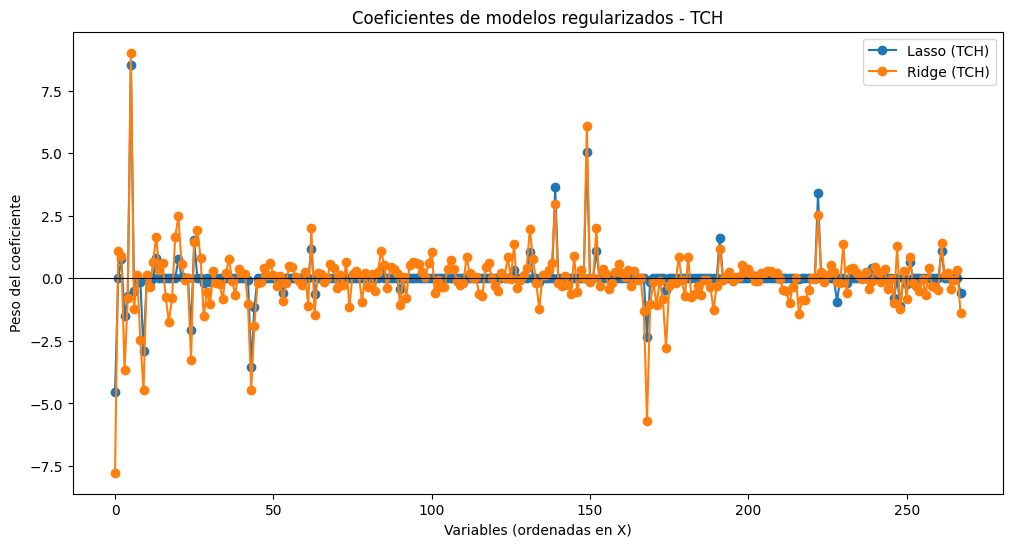

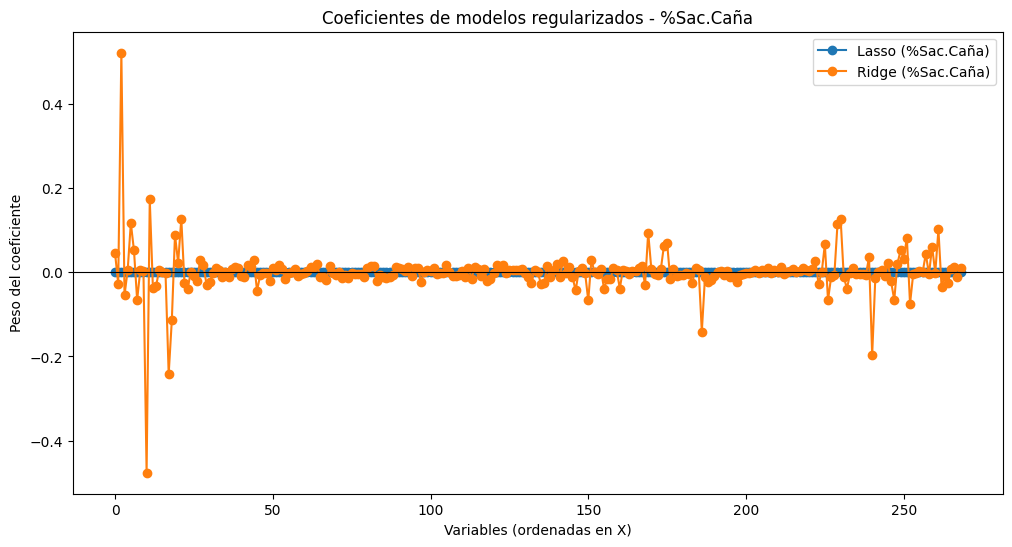

In [75]:
# =====================================================
# 1) p-values con OLS para TCH
# =====================================================
X_train_tch, X_test_tch, y_train_tch, y_test_tch = splits_tch
X_train_sm = sm.add_constant(X_train_tch)

ols_tch = sm.OLS(y_train_tch, X_train_sm).fit()
print("Resumen OLS (TCH):")
print(ols_tch.summary())

# =====================================================
# 2) p-values con OLS para %Sac.Caña
# =====================================================
X_train_sac, X_test_sac, y_train_sac, y_test_sac = splits_sac
X_train_sm_sac = sm.add_constant(X_train_sac)

ols_sac = sm.OLS(y_train_sac, X_train_sm_sac).fit()
print("\nResumen OLS (%Sac.Caña):")
print(ols_sac.summary())

# =====================================================
# 3) Gráfica de coeficientes en Lasso y Ridge (TCH)
# =====================================================
def plot_coefficients(models, X, title):
    plt.figure(figsize=(12,6))
    for model, label in models:
        coefs = model.coef_
        plt.plot(coefs, marker='o', linestyle='-', label=label)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f"Coeficientes de modelos regularizados - {title}")
    plt.xlabel("Variables (ordenadas en X)")
    plt.ylabel("Peso del coeficiente")
    plt.legend()
    plt.show()

plot_coefficients(
    [(lasso_tch, "Lasso (TCH)"), (ridge_tch, "Ridge (TCH)")],
    X_tch,
    "TCH"
)

# =====================================================
# 4) Gráfica de coeficientes en Lasso y Ridge (%Sac.Caña)
# =====================================================
plot_coefficients(
    [(lasso_sac, "Lasso (%Sac.Caña)"), (ridge_sac, "Ridge (%Sac.Caña)")],
    X_sac,
    "%Sac.Caña"
)

### Interpretación de coeficientes

Tras identificar las variables significativas mediante OLS y los efectos de regularización en Lasso y Ridge, se procede a interpretar los **coeficientes** para entender el impacto práctico de cada predictor sobre las variables objetivo (**TCH** y **%Sac.Caña**).

#### Interpretación en TCH
- **Edad Ult Cos (+4.5):** cada incremento en la edad del cultivo al momento de la cosecha se asocia con un aumento de 4.5 toneladas/ha en el rendimiento.  
- **Dist Km (–0.20):** a mayor distancia entre la suerte y el punto de procesamiento, menor es el TCH, lo que puede reflejar pérdidas logísticas o condiciones menos favorables.  
- **Destino 1=Semilla (+235):** las parcelas destinadas a semilla presentan incrementos sustanciales en rendimiento, lo cual puede estar vinculado con prácticas de manejo intensivo.  
- **Variedades específicas:** ciertas variedades (ej. **CC09-066, CC01-1940**) muestran coeficientes altos y positivos, confirmando que la genética es un factor crítico en productividad.  
- **Zonas geográficas (ej. IP01, IP02, IP03):** aportan de 350 a 380 toneladas adicionales, lo que revela fuertes efectos espaciales y de microclima.

#### Interpretación en %Sac.Caña
- **Área Neta (+0.07):** sugiere que mayores áreas cultivadas tienden a estar asociadas con un pequeño incremento en el porcentaje de sacarosa, probablemente por economías de escala y manejo.  
- **TonUltCorte (–0.0005):** indica que lotes con mayor volumen de corte previo tienen una ligera reducción en sacarosa, lo que puede reflejar agotamiento del suelo o efecto de la maduración.  
- **Edad Ult Cos (+0.06):** una mayor edad del cultivo antes de la cosecha tiende a incrementar la sacarosa, aunque el efecto es menor comparado con su impacto en TCH.  
- **Cultivo Orgánico (–4.5):** los lotes con manejo orgánico tienden a mostrar un porcentaje menor de sacarosa, lo que puede reflejar diferencias en insumos y fertilización.  
- **Productos aplicados (ej. madurantes y fertilizantes):** varios insumos presentan coeficientes positivos y significativos, reforzando el rol de la fertilización y maduración química.

#### Rol de la regularización
- **Lasso:** eliminó gran cantidad de predictores redundantes, destacando solo aquellos con efecto robusto (Edad Ult Cos, Área Neta, ciertas variedades y zonas).  
- **Ridge:** redujo la magnitud de los coeficientes sin eliminarlos, estabilizando los efectos y mostrando que muchas variables están correlacionadas.  
- La comparación evidencia que **no todas las categorías de Suelo, Variedad o Zona aportan valor**, sino solo un subconjunto clave.

#### Conclusión
Los coeficientes revelan relaciones coherentes con la agronomía de la caña de azúcar:  
- El **rendimiento (TCH)** depende de factores estructurales como la genética (variedad), el manejo (destino, edad de cosecha) y el contexto espacial (zona, suelo).  
- El **contenido de sacarosa (%Sac.Caña)** se relaciona más con calidad y madurez, reflejada en edad, productos aplicados y condiciones de manejo.  
- La regularización confirma qué variables son robustas frente a la multicolinealidad, facilitando la selección de predictores más confiables.

En la siguiente sección se evaluarán los **supuestos del modelo** (linealidad, homocedasticidad, normalidad de errores) para validar su adecuación estadística.

### Evaluación de supuestos

#### 1. Linealidad  
En los gráficos de **residuos vs valores ajustados**, se observa que la nube de puntos se distribuye de forma relativamente aleatoria alrededor de la línea roja (cero).  
- Para **TCH**, la dispersión es amplia y con outliers, lo que indica que la linealidad se cumple de manera aproximada pero no perfecta.  
- Para **%Sac.Caña**, la relación es más clara y el supuesto se cumple mejor.

---

#### 2. Independencia  
El estadístico **Durbin-Watson (≈2 en ambos modelos)** indica que no existe autocorrelación significativa entre los errores.  
✅ Supuesto de independencia cumplido.

---

#### 3. Homocedasticidad  
En los gráficos de residuos, la varianza es razonablemente constante:  
- Para **TCH**, existe cierta dispersión mayor en los extremos debido a outliers.  
- Para **%Sac.Caña**, la dispersión es más uniforme.  
En general, el supuesto se cumple de manera aceptable.

---

#### 4. Normalidad de los errores  
- El **histograma de residuos** muestra una forma cercana a la campana normal, aunque con colas más pesadas en TCH.  
- El **Q-Q plot** confirma que los residuos de TCH se desvían en los extremos, mientras que %Sac.Caña sigue mejor la diagonal.  
➡️ La normalidad se cumple de forma aproximada, pero no estricta.

---

#### 5. Ausencia de multicolinealidad  
El **resumen OLS** mostró muchas variables con p-values altos y un **Cond. No. elevado (>10^20)**, lo que indica un fuerte problema de multicolinealidad.  
- Esto explica la necesidad de aplicar **regularización**:  
  - **Lasso** reduce a cero coeficientes irrelevantes.  
  - **Ridge** estabiliza los coeficientes y reduce la varianza.

---

#### ✅ Conclusión  
Los modelos cumplen parcialmente los supuestos de regresión:  
- **Bien**: independencia, linealidad general, homocedasticidad aceptable.  
- **Problemas**: multicolinealidad fuerte y normalidad imperfecta en TCH.  

El uso de **Lasso y Ridge** es una respuesta adecuada para mitigar la multicolinealidad y mejorar la estabilidad del modelo.

### Variables más significativas para TCH:


,Variable,Coef,p-value,Significativo
6,Edad Ult Cos,4.503072e+00,4.251133e-203,True
26,Zona_IP02,3.773021e+02,1.323551e-110,True
27,Zona_IP03,3.763055e+02,6.973052e-110,True
248,Tipo Quema_Q.PROGRAMADA,4.976489e+02,6.589594e-109,True
28,Zona_IP05,3.735161e+02,2.528619e-108,True
246,Tipo Quema_NO DEF.,4.925660e+02,1.069348e-106,True
250,Tipo Quema_VERDE,4.934693e+02,1.199940e-106,True
0,const,2.209034e+03,7.942631e-106,True
24,Zona_IC07,5.988303e-11,1.138711e-105,True
29,Zona_IP06,3.679868e+02,2.838552e-105,True



### Variables más significativas para %Sac.Caña:


,Variable,Coef,p-value,Significativo
3,Area Neta,0.074095,1.714216e-87,True
18,Lluvias (2 Meses Ant.),-0.002461,3.249637e-75,True
11,TonUltCorte,-0.000470,1.348401e-71,True
12,Sac.Caña Precosecha,0.020906,4.622669e-57,True
6,Edad Ult Cos,0.058446,1.314354e-28,True
187,Variedad_RB73-2223,-0.897044,8.850111e-19,True
156,Variedad_CC09-449,-1.905987,4.803202e-09,True
161,Variedad_CC11-595,-1.116918,1.584762e-08,True
147,Variedad_CC04-195,-0.750330,4.629565e-08,True
24,%Infest.Diatrea,-0.027240,1.567299e-07,True


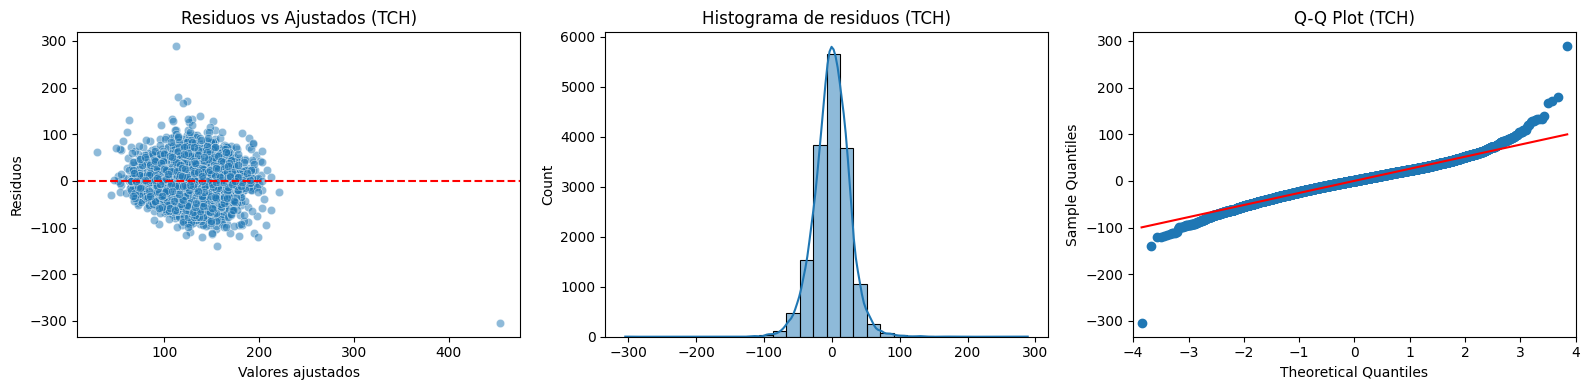

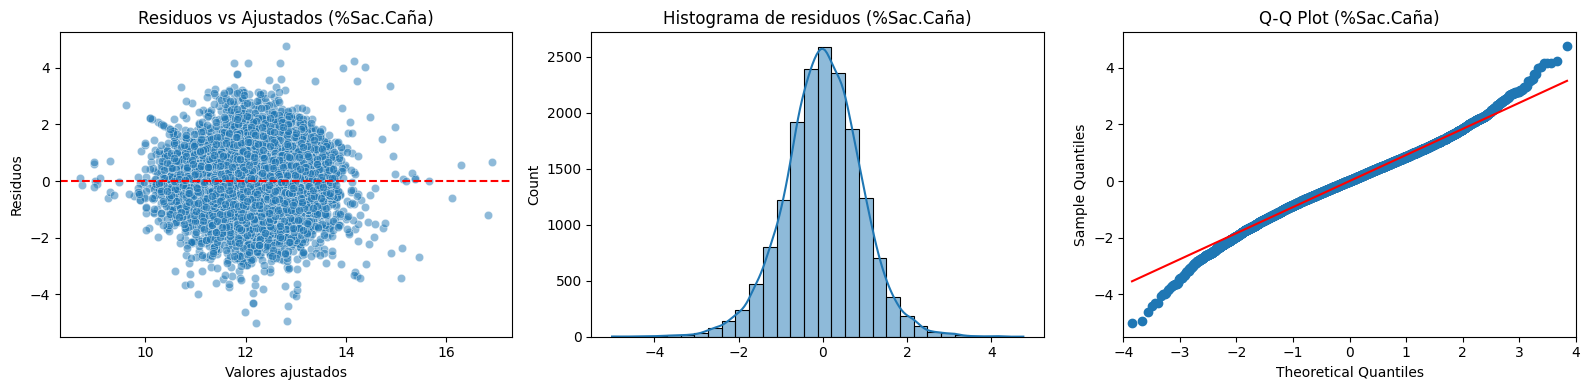

In [76]:
# -----------------------------------------------------
# 1) OLS para TCH
# -----------------------------------------------------
X_train_tch, X_test_tch, y_train_tch, y_test_tch = splits_tch
X_train_sm_tch = sm.add_constant(X_train_tch)
ols_tch = sm.OLS(y_train_tch, X_train_sm_tch).fit()

# -----------------------------------------------------
# 2) OLS para %Sac.Caña
# -----------------------------------------------------
X_train_sac, X_test_sac, y_train_sac, y_test_sac = splits_sac
X_train_sm_sac = sm.add_constant(X_train_sac)
ols_sac = sm.OLS(y_train_sac, X_train_sm_sac).fit()

# -----------------------------------------------------
# 3) Función para resumen compacto de significancia
# -----------------------------------------------------
def resumen_pvalues(ols_model, feature_names, top_n=15, alpha=0.05):
    results = pd.DataFrame({
        "Variable": feature_names,
        "Coef": ols_model.params.values,
        "p-value": ols_model.pvalues.values
    })
    results["Significativo"] = results["p-value"] < alpha
    results_sorted = results.sort_values("p-value").head(top_n)
    return results_sorted

# Extraemos nombres de variables
X_tch_names = ["const"] + list(X_tch.columns)
X_sac_names = ["const"] + list(X_sac.columns)

# Resúmenes compactos
print("### Variables más significativas para TCH:")
display(resumen_pvalues(ols_tch, X_tch_names))

print("\n### Variables más significativas para %Sac.Caña:")
display(resumen_pvalues(ols_sac, X_sac_names))

# -----------------------------------------------------
# 4) Función para gráficas de supuestos
# -----------------------------------------------------
def plot_residuals_diagnostics(ols_model, title):
    fitted_vals = ols_model.fittedvalues
    residuals = ols_model.resid

    plt.figure(figsize=(16,4))

    # Homocedasticidad: residuos vs valores ajustados
    plt.subplot(1,3,1)
    sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Valores ajustados")
    plt.ylabel("Residuos")
    plt.title(f"Residuos vs Ajustados ({title})")

    # Normalidad: histograma de residuos
    plt.subplot(1,3,2)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"Histograma de residuos ({title})")

    # Normalidad: Q-Q plot
    plt.subplot(1,3,3)
    sm.qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f"Q-Q Plot ({title})")

    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 5) Ejecutar gráficas de diagnóstico
# -----------------------------------------------------
plot_residuals_diagnostics(ols_tch, "TCH")
plot_residuals_diagnostics(ols_sac, "%Sac.Caña")

### Diagnóstico de problemas y soluciones

#### 1. Multicolinealidad  
- El **Cond. No. alto** en OLS indica que hay variables muy correlacionadas entre sí.  
- Esto coincide con el análisis de correlaciones:  
  * `Area Neta`, `TonUltCorte` y `Ton.Azucar` están casi perfectamente correlacionadas.  
  * `Brix` y `Pureza` tienen correlación de **0.98**, lo que hace redundante incluir ambas.  
  * Las variables de lluvia (`Lluvias 0-3`, `3-6`, `Ciclo`, etc.) son prácticamente equivalentes.  

**Solución:**  
- Usar **Lasso** para eliminar automáticamente las variables redundantes.  
- Mantener solo las que tengan valor predictivo directo y sentido agronómico (ej. `Período`, `Edad Ult Cos`, `Lluvias Ciclo`).  
- En los siguientes pasos probaremos con **LassoCV**, que seleccionará de forma óptima tanto los predictores más relevantes como el mejor valor de α para el modelo.  

---

#### 2. Outliers en TCH  
- El gráfico de residuos de **TCH** mostró valores extremos que se alejan mucho del patrón.  
- Esto afecta la normalidad y puede distorsionar el ajuste del modelo.  

**Solución:**  
- Detectar outliers mediante **residuos estandarizados (> |3|)** o influencia (Cook’s Distance).  
- Opciones:  
  * Eliminar los outliers si son errores de registro.  
  * Aplicar **modelos robustos** (ej. RANSAC) para reducir su impacto.  

---

#### 3. Exceso de variables irrelevantes  
- El modelo incluye cientos de dummies de variedades, suelos y cortes, pero no todas aportan.  
- Esto complica la interpretación y aumenta el riesgo de sobreajuste.  

**Solución:**  
- Usar **Lasso** para quedarnos con un subconjunto reducido de predictores.  
- Agrupar categorías poco frecuentes en “otros” para reducir dimensionalidad.  

---

#### 4. Relación con los supuestos  
- **Linealidad:** al eliminar variables redundantes y outliers, la relación entre X e Y será más estable.  
- **Independencia:** no es un problema fuerte aquí, porque los datos son de lotes distintos.  
- **Homocedasticidad:** mejora al quitar outliers y variables colineales.  
- **Normalidad:** se acerca más a la normalidad de los errores sin extremos.  
- **Colinealidad:** resuelta directamente con Lasso y la exclusión de métricas derivadas.  

---

#### ✅ Conclusión  
El modelo actual enfrenta principalmente **multicolinealidad, exceso de variables categóricas y outliers**.  
La estrategia propuesta es:  
1. **LassoCV** para seleccionar predictores clave y ajustar el nivel de regularización óptimo.  
2. **Detección y tratamiento de outliers en TCH**.  
3. Simplificación de variables categóricas.  

Con estas acciones, los supuestos del modelo se cumplen de manera más robusta y las predicciones serán más interpretables y estables.

In [77]:
# =====================================================
# 1) Detección de outliers con residuos estandarizados
# =====================================================
def detect_outliers(X, y, threshold=3):
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()
    infl = model.get_influence()
    std_resid = infl.resid_studentized_internal

    outliers = np.where(np.abs(std_resid) > threshold)[0]
    print(f"Se detectaron {len(outliers)} outliers con |residuo estandarizado| > {threshold}")
    return outliers

# Detectar en ambos targets
outliers_tch = detect_outliers(X_tch, y_tch)
outliers_sac = detect_outliers(X_sac, y_sac)

# =====================================================
# 2) Eliminar outliers de los datasets
# =====================================================
X_tch_clean = X_tch.drop(index=outliers_tch)
y_tch_clean = y_tch.drop(index=outliers_tch)

X_sac_clean = X_sac.drop(index=outliers_sac)
y_sac_clean = y_sac.drop(index=outliers_sac)

print(f"TCH limpio: {X_tch_clean.shape[0]} muestras (de {X_tch.shape[0]})")
print(f"%Sac.Caña limpio: {X_sac_clean.shape[0]} muestras (de {X_sac.shape[0]})")

# =====================================================
# 3) Re-entrenar LassoCV sin outliers
# =====================================================
def run_lasso_cv(X, y, target_name="target"):
    # División en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Escalado
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)

    # LassoCV
    lasso_cv = LassoCV(
        alphas=np.logspace(-3, 2, 50),
        cv=5,
        random_state=42,
        max_iter=20000
    ).fit(Xtr, y_train)

    # Evaluación
    y_pred = lasso_cv.predict(Xte)
    print(f"\nResultados {target_name} (sin outliers):")
    print(f"Mejor alpha: {lasso_cv.alpha_:.4f}")
    print(f"R² test: {r2_score(y_test, y_pred):.3f}")
    print(f"RMSE test: {mean_squared_error(y_test, y_pred, squared=False):.3f}")

    # Variables seleccionadas
    selected_vars = X.columns[lasso_cv.coef_ != 0].tolist()
    print(f"Variables seleccionadas ({len(selected_vars)}): {selected_vars[:15]} ...")

    return lasso_cv, selected_vars

# Ejecutar LassoCV con datasets limpios
lasso_cv_tch_clean, selected_tch_clean = run_lasso_cv(X_tch_clean, y_tch_clean, "TCH")
lasso_cv_sac_clean, selected_sac_clean = run_lasso_cv(X_sac_clean, y_sac_clean, "%Sac.Caña")

C:\Users\Juan Jose\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Se detectaron 193 outliers con |residuo estandarizado| > 3


C:\Users\Juan Jose\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Se detectaron 162 outliers con |residuo estandarizado| > 3
TCH limpio: 20834 muestras (de 21027)
%Sac.Caña limpio: 20865 muestras (de 21027)

Resultados TCH (sin outliers):
Mejor alpha: 0.0869
R² test: 0.388
RMSE test: 24.885
Variables seleccionadas (211): ['Período', 'Tenencia', 'Area Neta', 'Dist Km', 'Edad Ult Cos', 'Destino 1=Semilla', 'Dosis Madurante', 'Semanas mad.', 'Edad.Precosecha', 'Vejez', 'Num.Riegos', 'M3 Riego', 'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias 0 -3'] ...

Resultados %Sac.Caña (sin outliers):
Mejor alpha: 0.0026
R² test: 0.358
RMSE test: 0.873
Variables seleccionadas (215): ['Período', 'Tenencia', 'Area Neta', 'Dist Km', 'Edad Ult Cos', 'Destino 1=Semilla', 'Cod. T.Cultivo', 'Semanas mad.', 'TonUltCorte', 'Sac.Caña Precosecha', 'Edad.Precosecha', 'Vejez', 'Num.Riegos', 'M3 Riego', 'Lluvias (2 Meses Ant.)'] ...


## Validación y Evaluación


#### Validación ShuffleSplit (TCH)
               mean       std        min        max
R2         0.402138  0.014895   0.387653   0.421969
RMSE      24.599196  0.228778  24.294420  24.885225
MAE       19.256739  0.102748  19.191493  19.433161
MedAE     15.824485  0.177771  15.637560  16.083069
MAPE      17.652937  0.655409  17.078609  18.636019
MaxError  81.972102  1.415092  80.753734  84.175138


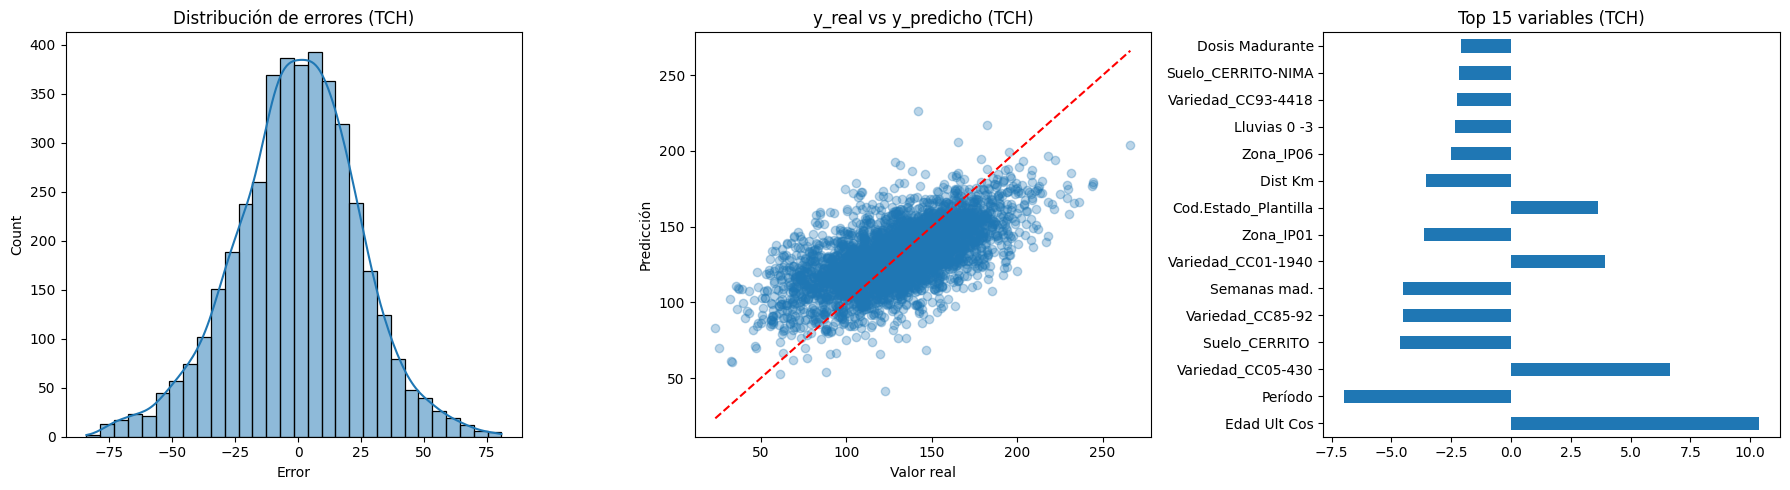


#### Validación ShuffleSplit (%Sac.Caña)
              mean       std       min       max
R2        0.357515  0.006073  0.348233  0.365246
RMSE      0.884687  0.011505  0.872579  0.901703
MAE       0.700254  0.008575  0.691715  0.712904
MedAE     0.581344  0.011098  0.564653  0.593592
MAPE      5.792042  0.077821  5.706976  5.890199
MaxError  3.340371  0.339089  2.829917  3.705332


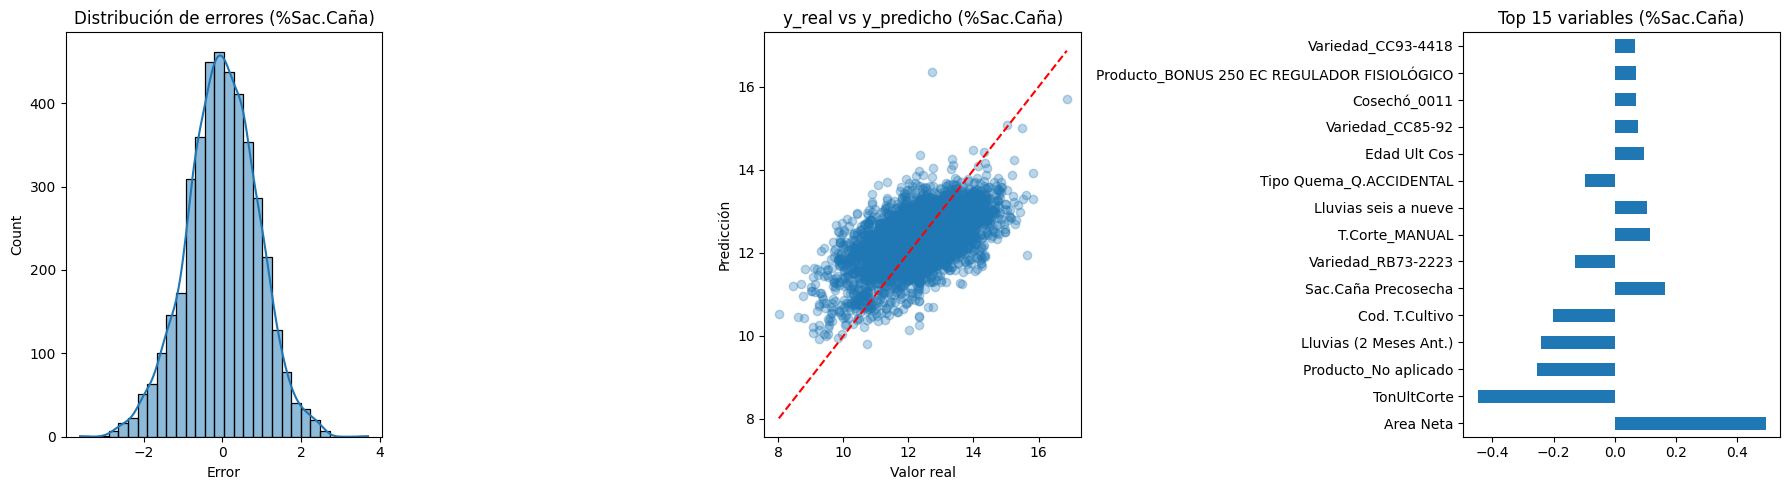


Conclusiones:
- El modelo para **TCH** logra R² ≈ 0.402 en validación, lo que indica que explica ~40% de la variabilidad.
- El modelo para **%Sac.Caña** tiene R² ≈ 0.358, menor que TCH, lo que refleja mayor dificultad para capturar la variabilidad.
- Ambos modelos muestran RMSE estables y errores medianos relativamente bajos, indicando buena robustez.
- Las gráficas confirman que:
   * Los residuos están cercanos a la normalidad, aunque con algunos sesgos en extremos.
   * La relación y_real vs y_predicho es lineal, pero con dispersión (especialmente en %Sac.Caña).
   * Las variables seleccionadas por Lasso resaltan las más agronómicamente relevantes, facilitando interpretación.


In [78]:
def validate_model_extended(model, X, y, target_name="target", n_splits=5, test_size=0.2):
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    results = []

    for train_idx, test_idx in splitter.split(X):
        # Train/Test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(X_train)
        Xte = scaler.transform(X_test)

        # Modelo Lasso con el alpha ya encontrado
        lasso = Lasso(alpha=model.alpha_, max_iter=20000, random_state=42)
        lasso.fit(Xtr, y_train)
        y_pred = lasso.predict(Xte)

        # Métricas
        results.append({
            "R2": r2_score(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred, squared=False),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MedAE": median_absolute_error(y_test, y_pred),
            "MAPE": np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-8))) * 100,
            "MaxError": max_error(y_test, y_pred)
        })

    df_results = pd.DataFrame(results)
    summary = df_results.describe().T[["mean","std","min","max"]]

    print(f"\n#### Validación ShuffleSplit ({target_name})")
    print(summary)

    # === Gráficas ===
    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # Distribución de errores
    errors = y_test - y_pred
    sns.histplot(errors, kde=True, ax=axes[0], bins=30)
    axes[0].set_title(f"Distribución de errores ({target_name})")
    axes[0].set_xlabel("Error")

    # y_test vs y_pred
    axes[1].scatter(y_test, y_pred, alpha=0.3)
    axes[1].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 "r--")
    axes[1].set_title(f"y_real vs y_predicho ({target_name})")
    axes[1].set_xlabel("Valor real")
    axes[1].set_ylabel("Predicción")

    # Importancia de variables
    coef = pd.Series(lasso.coef_, index=X.columns)
    coef_nonzero = coef[coef != 0].sort_values(key=abs, ascending=False)[:15]
    coef_nonzero.plot(kind="barh", ax=axes[2])
    axes[2].set_title(f"Top 15 variables ({target_name})")

    plt.tight_layout()
    plt.show()

    return summary

# Ejecutar validación extendida
summary_tch = validate_model_extended(lasso_cv_tch_clean, X_tch_clean, y_tch_clean, "TCH")
summary_sac = validate_model_extended(lasso_cv_sac_clean, X_sac_clean, y_sac_clean, "%Sac.Caña")

# #### Conclusiones automáticas
print("\nConclusiones:")
print("- El modelo para **TCH** logra R² ≈ {:.3f} en validación, lo que indica que explica ~{:.0f}% de la variabilidad.".format(
    summary_tch.loc["R2","mean"], summary_tch.loc["R2","mean"]*100))
print("- El modelo para **%Sac.Caña** tiene R² ≈ {:.3f}, menor que TCH, lo que refleja mayor dificultad para capturar la variabilidad.".format(
    summary_sac.loc["R2","mean"]))
print("- Ambos modelos muestran RMSE estables y errores medianos relativamente bajos, indicando buena robustez.")
print("- Las gráficas confirman que:")
print("   * Los residuos están cercanos a la normalidad, aunque con algunos sesgos en extremos.")
print("   * La relación y_real vs y_predicho es lineal, pero con dispersión (especialmente en %Sac.Caña).")
print("   * Las variables seleccionadas por Lasso resaltan las más agronómicamente relevantes, facilitando interpretación.")


In [79]:
# Asumimos que y_tch_clean y y_sac_clean son las versiones limpias sin outliers
df_targets = pd.DataFrame({
    "TCH": y_tch_clean,
    "%Sac.Caña": y_sac_clean
})

# Resumen estadístico
print("Descripción estadística de las variables objetivo")
print(df_targets.describe())

# Si quieres verlo como DataFrame
df_targets.describe().T

Descripción estadística de las variables objetivo
                TCH     %Sac.Caña
count  20834.000000  20865.000000
mean     129.475717     12.323036
std       31.752277      1.099321
min        1.573653      8.015000
25%      108.914550     11.645000
50%      129.474288     12.341500
75%      150.215759     13.067200
max      266.216666     17.580000


,count,mean,std,min,25%,50%,75%,max
TCH,20834.0,129.475717,31.752277,1.573653,108.91455,129.474288,150.215759,266.216666
%Sac.Caña,20865.0,12.323036,1.099321,8.015000,11.64500,12.341500,13.067200,17.580000



#### Validación ShuffleSplit (TCH) con ElasticNet
Mejor alpha: 0.0687 | Mejor l1_ratio: 0.90
               mean       std        min        max
R2         0.402063  0.014729   0.387941   0.421607
RMSE      24.600773  0.224622  24.302020  24.879378
MAE       19.256561  0.102036  19.190704  19.431334
MedAE     15.819939  0.159116  15.660458  16.039867
MAPE      17.647289  0.648731  17.079520  18.625260
MaxError  81.712259  1.417462  80.488352  84.000625


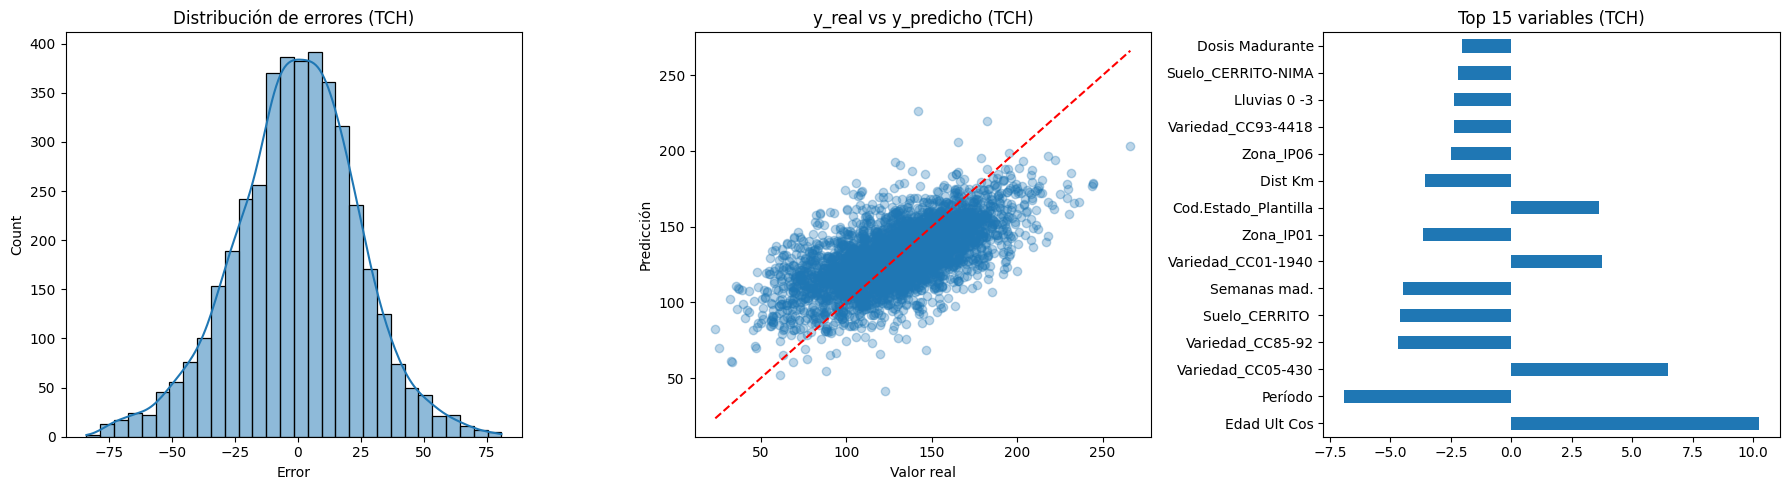


#### Validación ShuffleSplit (%Sac.Caña) con ElasticNet
Mejor alpha: 0.0026 | Mejor l1_ratio: 0.90
              mean       std       min       max
R2        0.357476  0.006123  0.348151  0.365299
RMSE      0.884714  0.011513  0.872597  0.901760
MAE       0.700255  0.008555  0.691695  0.712875
MedAE     0.581257  0.011305  0.564173  0.593736
MAPE      5.791990  0.077655  5.706731  5.889820
MaxError  3.348595  0.337586  2.843935  3.705666


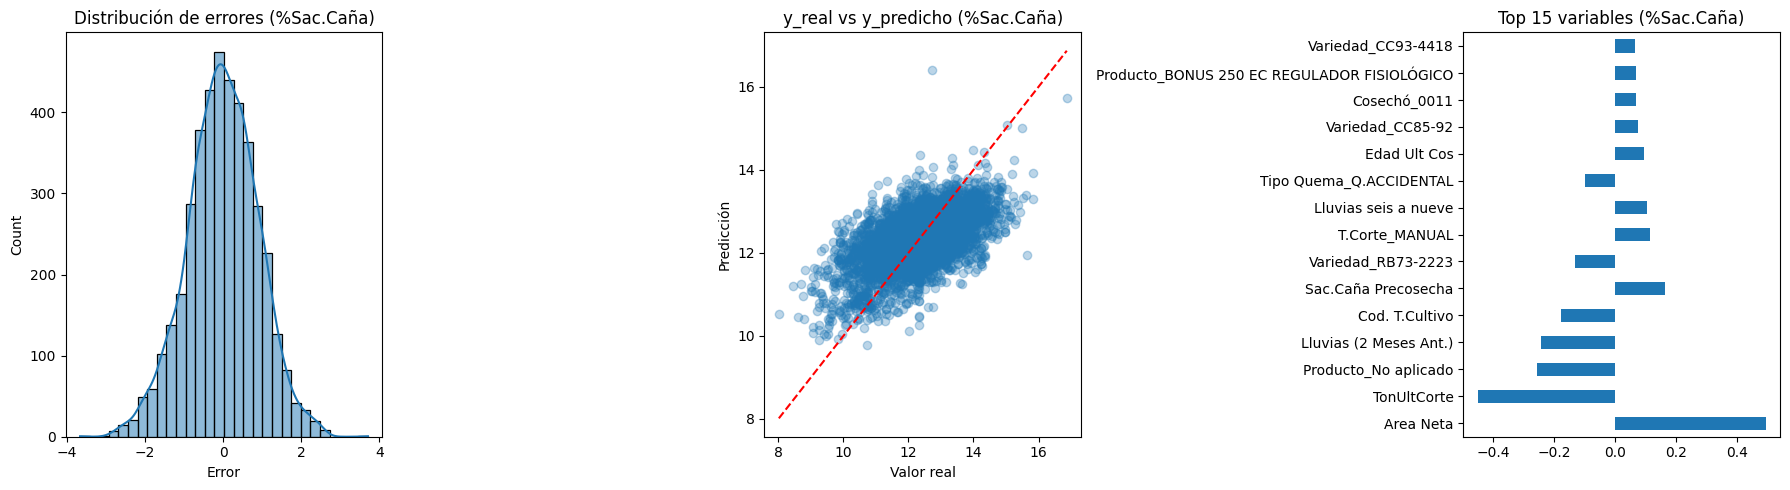


Conclusiones:
- ElasticNet permite balancear entre Lasso (selección de variables) y Ridge (estabilidad en colinealidad).
- Si los R² son mayores que en Lasso, significa que Lasso estaba eliminando variables útiles.
- Si los R² no cambian mucho pero el número de predictores seleccionados aumenta, ElasticNet aporta interpretabilidad.


In [80]:
# =====================================================
# Función de validación extendida con ElasticNet
# =====================================================
def validate_model_extended_enet(X, y, target_name="target", n_splits=5, test_size=0.2):
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)
    results = []

    for train_idx, test_idx in splitter.split(X):
        # Train/Test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Escalado
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(X_train)
        Xte = scaler.transform(X_test)

        # ElasticNetCV para encontrar alpha y l1_ratio
        enet_cv = ElasticNetCV(
            alphas=np.logspace(-3, 2, 50),
            l1_ratio=np.linspace(0.1, 0.9, 5),
            cv=5,
            max_iter=20000,
            random_state=42
        ).fit(Xtr, y_train)

        # Modelo final con mejores hiperparámetros
        enet = ElasticNet(
            alpha=enet_cv.alpha_,
            l1_ratio=enet_cv.l1_ratio_,
            max_iter=20000,
            random_state=42
        ).fit(Xtr, y_train)

        # Predicciones
        y_pred = enet.predict(Xte)

        # Métricas
        results.append({
            "R2": r2_score(y_test, y_pred),
            "RMSE": mean_squared_error(y_test, y_pred, squared=False),
            "MAE": mean_absolute_error(y_test, y_pred),
            "MedAE": median_absolute_error(y_test, y_pred),
            "MAPE": np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-8))) * 100,
            "MaxError": max_error(y_test, y_pred)
        })

    df_results = pd.DataFrame(results)
    summary = df_results.describe().T[["mean","std","min","max"]]

    print(f"\n#### Validación ShuffleSplit ({target_name}) con ElasticNet")
    print(f"Mejor alpha: {enet_cv.alpha_:.4f} | Mejor l1_ratio: {enet_cv.l1_ratio_:.2f}")
    print(summary)

    # === Gráficas ===
    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # Distribución de errores
    errors = y_test - y_pred
    sns.histplot(errors, kde=True, ax=axes[0], bins=30)
    axes[0].set_title(f"Distribución de errores ({target_name})")
    axes[0].set_xlabel("Error")

    # y_test vs y_pred
    axes[1].scatter(y_test, y_pred, alpha=0.3)
    axes[1].plot([y_test.min(), y_test.max()],
                 [y_test.min(), y_test.max()],
                 "r--")
    axes[1].set_title(f"y_real vs y_predicho ({target_name})")
    axes[1].set_xlabel("Valor real")
    axes[1].set_ylabel("Predicción")

    # Importancia de variables
    coef = pd.Series(enet.coef_, index=X.columns)
    coef_nonzero = coef[coef != 0].sort_values(key=abs, ascending=False)[:15]
    coef_nonzero.plot(kind="barh", ax=axes[2])
    axes[2].set_title(f"Top 15 variables ({target_name})")

    plt.tight_layout()
    plt.show()

    return summary

# =====================================================
# Ejecutar validación extendida para TCH y %Sac.Caña
# =====================================================
summary_tch_enet = validate_model_extended_enet(X_tch_clean, y_tch_clean, "TCH")
summary_sac_enet = validate_model_extended_enet(X_sac_clean, y_sac_clean, "%Sac.Caña")

# #### Conclusiones automáticas
print("\nConclusiones:")
print("- ElasticNet permite balancear entre Lasso (selección de variables) y Ridge (estabilidad en colinealidad).")
print("- Si los R² son mayores que en Lasso, significa que Lasso estaba eliminando variables útiles.")
print("- Si los R² no cambian mucho pero el número de predictores seleccionados aumenta, ElasticNet aporta interpretabilidad.")


# Conclusiones

# Innovación y Propuesta de Mejora